# Testbed Radio Schedule

This notebook implements compute and simulation -based estimates to find appropriate parameters for a radio layer that satisfies the OpenSwarm 1,000 DotBot testbed.

The selected radio layer is BLE at 2 Mb/s, and the target parameters are:
- number of nodes: how many nodes can a single gateway support
- latency: how long does it take for messages to travel around in the system; also related to duration of OTAP updates.
- join speed: how long does it take for several nodes to join a gateway via a shared upstream slot

The parameters to be selected are:
- slotframe-related parameters:
    - duration of a single slot, e.g., 2 ms
    - composition of the slotframe, e.g., how many beacon, upstream, downstream, and shared upstream slots
- backoff window parameters:
    - n_min and n_max, which control the random backoff component to avoid contention during network join

The simulation also considers runtime configurations:
- for a gateway:
    - at each slot, the gateway has a probability P of sending down a packet, e.g., P = 10%; 
      this simulates random activity received from the MQTT broker
    - every X seconds, the gateway sends a batch of _unicast packets the need acknowledgment_, e.g., every 30 s; 
      this simulates a user attempt to reposition all robots at once
- for a node:
    - every X seconds, the node sends a status packet, e.g, 300 ms
    - every X seconds, the node sends a packet that requires acknowledgment, e.g., every 5 s; 
      this simulates a node trying to request some information from the PyDotBot controller, User UI, or Security Authority


In [1]:
# pip install rich numpy pandas matplotlib scikit-learn

import rich, math, sys, time, random, copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from rich.console import Console
from rich.live import Live
from rich.text import Text
from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any, Optional, ClassVar, Union
from functools import reduce
from IPython.display import clear_output  # For Jupyter compatibility

In [402]:
# constants
FIRST_PRIMES_BEFORE_200 = [
    2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47,
    53, 59, 61, 67, 71, 73, 79, 83, 89, 97,
    101, 103, 107, 109, 113, 127, 131, 137, 139, 149,
    151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199
]

N_BEACON_FREQS = 3
BLE_FREQUENCIES = range(0, 40-N_BEACON_FREQS)
BLE_ADV_FREQUENCIES = range(40-N_BEACON_FREQS, 40)

BLE_BANDWIDTH = 1000 * 1000 * 2 # b/s
BLE_BANDWIDTH_B_MS = BLE_BANDWIDTH / 8 / 1000 # B/ms
TIME_PADDING = 1 # ms

@dataclass
class Packet:
    mtu: int = 256 # B

    @property
    def toa(self):
        return self.mtu / BLE_BANDWIDTH_B_MS # about 1.02 ms

PACKET = Packet()

SLOT_INFO = {
    "beacon": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "B",
        "color": "red",
    },
    "data-down": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "D",
        "color": "green",
    },
    "data-up": {
        "direction": "up",
        "is_shared": False,
        "abbreviation": "U",
        "color": "yellow",
    },
    "data-shared-up": {
        "direction": "up",
        "is_shared": True,
        "abbreviation": "S",
        "color": "purple",
    },

    # not used anymore -- will just use data-down for carrying join-response packets
    "join-response": {
        "direction": "down",
        "is_shared": True,
        "abbreviation": "R",
        "color": "deep_pink3",
    },

    # so far not used
    "empty": {
        "direction": "n/a",
        "is_shared": False,
        "abbreviation": "E",
        "color": "white",
    },
}

@dataclass
class Slot:
    type: str
    start: Optional[float] = None
    id: Optional[int] = None
    asn: Optional[int] = None
    assigned_node_id: Optional[int] = None
    assigned_channel_offset: Optional[int] = None

    def __post_init__(self):
        assert self.type in SLOT_INFO, f"Unknown slot type: {self.type}"

    @staticmethod
    def from_abbreviation(abbrev):
        for type, info in SLOT_INFO.items():
            if info["abbreviation"] == abbrev:
                return Slot(type)
        raise ValueError(f"Unknown slot abbreviation: {ord(abbrev)}")

    @property
    def direction(self):
        return SLOT_INFO[self.type]["direction"]

    @property
    def is_shared(self):
        return SLOT_INFO[self.type]["is_shared"]

    @property
    def duration(self):
        return PACKET.toa + TIME_PADDING

    @property
    def end(self):
        return round(self.start + self.duration, 2)
    
    @property
    def abbrev(self):
        return SLOT_INFO[self.type]["abbreviation"]
    
    @property
    def is_scheduled(self):
        return self.assigned_node_id is not None
    
    def assign_node_id(self, node_id):
        self.assigned_node_id = node_id

    def assign_channel_offset(self, channel_offset):
        self.assigned_channel_offset = channel_offset

    def __str__(self):
        # return f"{self.type} slot, from {self.start:.2f} to {self.end:.2f} (asn {self.asn}, {PACKET.mtu} B Packet)"
        return f"Slot({self.abbrev}, {self.id}, duration={self.duration:.2f}, asn={self.asn}, start={self.start:.2f})"
    
    def __repr__(self):
        return self.__str__()

    def repr_nice(self, compact=False):
        """
        Return a single character with rich-based background color (based on type).
        """
        abbrev = SLOT_INFO[self.type]['abbreviation']
        color = SLOT_INFO[self.type]["color"]
        direction = "↓" if self.direction == "down" else " " # invisible space!!
        if compact:
            # return rich.text.Text(abbrev, style=f'bold {color} on {color}')
            if self.direction == "down":
                return rich.text.Text("↓", style=f'bold white on {color}')
            elif self.abbrev == "U" and self.is_scheduled:
                return rich.text.Text(abbrev, style=f'bold yellow2 on {color}')
            return rich.text.Text(abbrev, style=f'bold {color} on {color}')
        else:
            # add invisible []'s because space doesn't work well with newlines
            hidden_left = rich.text.Text("[", style=f'bold {color} on {color}')
            chr = rich.text.Text(abbrev, style=f'bold white on {color}')
            if self.direction == "down":
                hidden_right = rich.text.Text("↓", style=f'bold white on {color}')
            elif self.abbrev == "U" and self.is_scheduled:
                hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
                chr = rich.text.Text(f"{self.assigned_node_id}", style=f'bold white on {color}')
                # chr = rich.text.Text(f"{self.assigned_channel_offset}", style=f'bold blue on {color}')
            else:
                hidden_right = rich.text.Text("]", style=f'bold {color} on {color}')
            return hidden_left + chr + hidden_right

    def repr_time(self):
        """Show id, asn, and start"""
        return f"{self.abbrev} #{self.id}:\tasn={self.asn}, start={self.start:.2f})"

    # as scheduled cells

    def repr_c_cells(self):
        """Return it like a C struct."""
        node_id = self.assigned_node_id if self.assigned_node_id is not None else "null"
        return f"{{'{self.abbrev}', {self.assigned_channel_offset}, {node_id}}}"

    def repr_python_cell(self):
        """Return it like a Python tuple."""
        return f"({self.id}, '{self.abbrev}', {self.assigned_channel_offset}, {self.assigned_node_id})"
    
    def get_cell_tuple(self):
        return (self.abbrev, self.assigned_channel_offset, self.assigned_node_id)

class SlotFactory:
    def beacon(n=3):
        return [Slot("beacon") for _ in range(n)]

    def join_request(n):
        return [Slot("data-up-shared") for _ in range(n)]

    def data_down(n):
        return [Slot("data-down") for _ in range(n)]

    def data_up(n):
        return [Slot("data-up") for _ in range(n)]

@dataclass
class Slotframe:
    slots: list[Slot]
    current_index: int = 0
    label: str = None

    def __post_init__(self):
        if not self.label:
            self.label = f"sf_{self.slot_count}"

    @staticmethod
    def from_nested(nested_slots):
        """Creates a Slotframe from nested slots, supporting both lists and single Slot objects."""
        # Use reduce to flatten nested structures automatically
        def flatten(acc, item):
            if isinstance(item, list):
                return acc + item
            return acc + [item]
        
        slots = reduce(flatten, nested_slots if isinstance(nested_slots, list) else [nested_slots], [])
        return Slotframe(slots)

    @staticmethod
    def build(abbreviations, id=0, start=0, asn=0, channel_offsets=None, label=None):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        slots = [Slot.from_abbreviation(abbrev) for abbrev in abbreviations if abbrev != " " and abbrev != "\n"]
        # create a random / shuffled, non-repeating list of channel offsets, from 0 to len(slots)
        if channel_offsets is None:
            n_beacon_slots = len([slot for slot in slots if slot.abbrev == "B"])
            regular_channel_offsets = list(range(len(slots) - n_beacon_slots))
            random.shuffle(regular_channel_offsets)
            beacon_channel_offsets = list(range(n_beacon_slots)) # no need to shuffle, as we may want to assign them in order
        for slot in slots:
            slot.start = start
            start += slot.duration
            slot.asn = asn
            asn += 1
            slot.id = id
            id += 1
            if slot.abbrev == "B":
                slot.assign_channel_offset(beacon_channel_offsets.pop(0))
            else:
                slot.assign_channel_offset(regular_channel_offsets.pop(0))
        return Slotframe(slots, label=label)

    @staticmethod
    def build_blocks(assoc_slots, data_slots, repetitions=1):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots) * repetitions
        return Slotframe.build(abbreviations)

    @staticmethod
    def build_blocks2(data_slots, repeats_data=1, assoc_slots="BBB", repeats_assoc=1, force_prime="U", label=None):
        """Creates a Slotframe from a string of abbreviations, e.g., 'BDDUS' """
        abbreviations = (assoc_slots + data_slots * repeats_data) * repeats_assoc
        if force_prime in ["U", "D", "S", "B", "E"]:
            diff = abs(len(abbreviations) - Slotframe.closest_prime_above(len(abbreviations)))
            abbreviations += force_prime * diff
        return Slotframe.build(abbreviations, label=label)

    def __str__(self):
        return f"Slotframe: {len(self.slots)} slots"

    @property
    def slot_duration(self):
        return self.slots[0].duration

    @property
    def duration(self):
        return round(len(self.slots) * self.slot_duration, 2)
    
    @property
    def start(self):
        return round(self.slots[0].start, 2)
    
    @property
    def end(self):
        return round(self.slots[-1].end, 2)

    @property
    def slot_count(self):
        return len(self.slots)
    
    @property
    def current(self):
        return self.slots[self.current_index]
    
    def assign_next_available_uplink_slot(self, node_id, after=None):
        for slot in self.slots:
            if after is not None and slot.id < after:
                continue
            if slot.abbrev == "U" and slot.assigned_node_id is None:
                slot.assign_node_id(node_id)
                return slot
        raise ValueError("All uplink slots already taken.")
    
    def advance_slot(self):
        wrapped = False
        self.current_index += 1
        if self.current_index >= len(self.slots):
            new_slots = copy.deepcopy(self.slots)
            for i, slot in enumerate(new_slots):
                slot.start += self.duration
                slot.asn += self.slot_count

            self.slots = new_slots
            self.current_index = 0
            wrapped = True
        return wrapped

    def as_raw_abbreviations(self):
        return "".join([SLOT_INFO[slot.type]["abbreviation"] for slot in self.slots])

    def count_slots_per_type(self, abbreviations=False):
        """Count the number of slots per type."""
        counts = {}
        for slot in self.slots:
            if slot.type not in counts:
                counts[slot.type] = 1
            else:
                counts[slot.type] += 1
        if abbreviations:
            return {SLOT_INFO[type]["abbreviation"]: count for type, count in counts.items()}
        return counts

    def max_nodes(self):
        """Return the maximum number of nodes that can be scheduled in the slotframe."""
        return self.count_slots_per_type().get("data-up", 0)
    
    def ratio_data_up_to_data_down(self):
        return round(self.count_slots_per_type().get("data-up", 0) / self.count_slots_per_type().get("data-down", 1), 2)

    @staticmethod
    def closest_prime_number(n_slots):
        """Find the closest prime number to the number of slots."""
        return min(FIRST_PRIMES_BEFORE_200, key=lambda x: abs(x - len(n_slots)))

    @staticmethod
    def closest_prime_above(n_slots):
        """Find the closest prime number greater than or equal to the number of slots."""
        for prime in FIRST_PRIMES_BEFORE_200:
            if prime >= n_slots:
                return prime

    @staticmethod
    def closest_prime_below(n_slots):
        """Find the closest prime number less than or equal to the number of slots."""
        for prime in reversed(FIRST_PRIMES_BEFORE_200):
            if prime <= n_slots:
                return prime

    def find_first_slot(self, type):
        """Find the first slot of a given type, including index."""
        return next(((i, slot) for i, slot in enumerate(self.slots) if slot.type == type), (None, None))
    
    def find_last_slot(self, type):
        """Find the last slot of a given type, including index."""
        return next(((j, slot) for j, slot in reversed(list(enumerate(self.slots))) if slot.type == type), (None, None))

    def repr_nice(self, compact=False, start_slot=0):
        """Return a rich-based representation of the slotframe. Start at a specific slot index and wrap-around."""
        schedule = []
        for i, slot in enumerate(self.slots[start_slot:] + self.slots[:start_slot]):
            schedule.append(slot.repr_nice(compact))
        return rich.text.Text.assemble(*schedule)

    # as scheduled cells

    def repr_c_cells(self):
        """Return it like a C struct."""
        cells = ",\n        ".join([slot.repr_c_cells() for slot in self.slots])
        trailing_zero = ",\n        0" if len(self.slots) < 101 else ""
        return f"""\
#define N_CELLS_MAX 101

typedef struct {{
    char type;
    uint8_t channel_offset;
    node_id_t assigned_node_id;
}} cell_t;

typedef struct {{
    uint8_t backoff_n_min;
    uint8_t backoff_n_max;
    uint16_t slot_duration_us;
    size_t n_cells;
    cell_t cells[N_CELLS_MAX];
}} schedule_t;

schedule_t schedule_{len(self.slots)} = {{
    .backoff_n_min = 5,
    .backoff_n_max = 9,
    .slot_duration_us = {round(self.slot_duration * 1000)},
    .n_cells = {len(self.slots)},
    .cells = {{
        {cells}{trailing_zero}
    }}
}}
"""

    def repr_python_cells(self):
        """Return it like a Python list."""
        middle = ",\n    ".join([slot.repr_python_cell() for slot in self.slots])
        return f"""\
cells = [
    {middle}
]
"""

    def get_cell_tuples(self):
        return [slot.get_cell_tuple() for slot in self.slots]

    def show(self, compact=False):
        """Show the schedule of the slotframe."""
        console = Console()
        console.print(self.repr_nice(compact), end="\n", soft_wrap=compact)

    def show_stats(self, compact=False, otap_size=10_000):
        """Show scheduling statistics of the slotframe. Reuse the repr_nice method of the Slot class."""
        console = Console()
        schedule = [slot.repr_nice(compact) for slot in self.slots]
        console.print(f"Slotframe with {len(self.slots)} slots of {self.slot_duration:.2f} ms each (total {self.duration:.2f} ms):")
        # console.print(*schedule, end="\n")
        console.print(rich.text.Text.assemble(*schedule), end="\n", soft_wrap=compact)
        console.print(f"""\
- Max nodes: {self.max_nodes()} (number of data-up slots)

- MTU per slot: {PACKET.mtu} B
- Slot duration: {self.slot_duration:.2f} ms (TOA: {PACKET.toa:.2f} ms, PAD: {TIME_PADDING} ms)
- Number of slots per type: {self.count_slots_per_type()}
- Ratio of data-up to data-down slots: {self.ratio_data_up_to_data_down()}
""")
        return self


# example usage
# sf = Slotframe.build_blocks2(data_slots="SDUUU", repeats_data=3, assoc_slots="B", repeats_assoc=1, force_prime="E")
sf = Slotframe.build_blocks2(data_slots="SDUU", repeats_data=2, assoc_slots="B")
# sf.slots[4].assign_node_id(1)
sf.show_stats(compact=False)
# sf.as_raw_abbreviations()

Slotframe with 11 slots of 2.02 ms each (total 22.26 ms):

[B↓[S][D↓[U][U][S][D↓[U][U][U][U]

- Max nodes: 6 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 1, 'data-shared-up': 2, 'data-down': 2, 'data-up': 6}
- Ratio of data-up to data-down slots: 3.0

Slotframe(slots=[Slot(B, 0, duration=2.02, asn=0, start=0.00), Slot(S, 1, duration=2.02, asn=1, start=2.02), Slot(D, 2, duration=2.02, asn=2, start=4.05), Slot(U, 3, duration=2.02, asn=3, start=6.07), Slot(U, 4, duration=2.02, asn=4, start=8.10), Slot(S, 5, duration=2.02, asn=5, start=10.12), Slot(D, 6, duration=2.02, asn=6, start=12.14), Slot(U, 7, duration=2.02, asn=7, start=14.17), Slot(U, 8, duration=2.02, asn=8, start=16.19), Slot(U, 9, duration=2.02, asn=9, start=18.22), Slot(U, 10, duration=2.02, asn=10, start=20.24)], current_index=0, label='sf_11')

In [3]:
@dataclass
class Latency():
    sf: Slotframe

    def worst_case_downlink(self):
        """The diff between the last uplink and the first downlink."""
        i, first_down = self.sf.find_first_slot("data-down")
        j, last_up = self.sf.find_last_slot("data-up")
        return round(last_up.end - first_down.start, 2)
    def worst_case_uplink_estimate(self):
        """
        Just an estimate for the worst case latency, when all nodes are waiting for a downlink reply.

        - this is basically using the ratio of uplink to downlink slots, and assuming that we are the last in queue to receive a downlink reply.
        - this only makes sense for potential scenarios where the robot wants to perform a request-response style communication, e.g., EDHOC handshake.
        """
        sf_up = self.sf.count_slots_per_type()["data-up"]
        sf_down = self.sf.count_slots_per_type()["data-down"]
        needed_sf_n = math.ceil(sf_up / sf_down)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Latency worst case:

- downlink/uplink reply:            {self.worst_case_downlink()} ms
- uplink/downlink reply (estimate): {self.worst_case_uplink_estimate()} ms
    """)
    
Latency(sf).show_stats()

Latency worst case:

- downlink/uplink reply:            18.21 ms
- uplink/downlink reply (estimate): 66.78 ms

In [4]:
@dataclass
class OTAP:
    sf: Slotframe

    def duration(self, size=10_000):
        return self.get_stats(size)["duration"]

    def get_stats(self, size=10_000):
        swarmit_chunk_size = 128 # B
        packets = math.ceil(size / swarmit_chunk_size)
        data_down_slots = self.sf.count_slots_per_type()["data-down"]
        needed_slotframes = math.ceil(packets / data_down_slots)
        return {
            "image_size": math.ceil(size / 1024),
            "duration": round(needed_slotframes * self.sf.duration, 2),
            "packets": packets,
            "swarmit_chunk_size": swarmit_chunk_size,
            "needed_slotframes": needed_slotframes,
        }
        
    def show_stats(self, size=10_000):
        """Calculate the duration of an OTAP session."""
        stats = self.get_stats(size)
        console = Console()
        console.print(f"""\
OTAP update:

- Image size: {math.ceil(size / 1024)} kB
- Duration: {round(stats["duration"] / 1000, 2)} s

- Packets: {stats["packets"]}
- swarmit_chunk_size: {stats["swarmit_chunk_size"]} B
- Needed slotframes: {stats["needed_slotframes"]}
    """)
        
# example usage
OTAP(sf).show_stats()

OTAP update:

- Image size: 10 kB
- Duration: 0.89 s

- Packets: 79
- swarmit_chunk_size: 128 B
- Needed slotframes: 40

In [5]:
@dataclass
class Association():
    sf: Slotframe

    def max_time_no_collisions_est(self):
        """
        Just an estimate for the maximum association time, provided that there are no collisions.
        """
        sf_shared_up = self.sf.count_slots_per_type()["data-shared-up"]
        needed_sf_n = math.ceil(self.sf.max_nodes() / sf_shared_up)
        return round(needed_sf_n * self.sf.duration, 2)
    
    def show_stats(self):
        console = Console()
        console.print(f"""\
Association time:

- Max time no collisions (estimate):            {self.max_time_no_collisions_est()} ms
    """)
    
Association(sf).show_stats()

Association time:

- Max time no collisions (estimate):            66.78 ms

# Testing different schedules

In [381]:
@dataclass
class SFConfigs:
    slotframes: list[Slotframe]
    otap_size: int = 10_000

    def get_df(self):
        headers = [
            "slot_count", "U-max_nodes", "D-down", "S-join_req", "ratio_U_D",
            "sf_duration", "max_gw_req_res", "max_db_req_res", "otap_duration",
        ]
        stats = [
            [
                sf.slot_count,
                sf.max_nodes(),
                sf.count_slots_per_type()["data-down"],
                sf.count_slots_per_type()["data-shared-up"],
                sf.ratio_data_up_to_data_down(),
                sf.duration,
                Latency(sf).worst_case_downlink(),
                Latency(sf).worst_case_uplink_estimate(),
                OTAP(sf).duration(self.otap_size),
            ]
            for sf in self.slotframes
        ]

        return pd.DataFrame(stats, columns=headers)

    def show_df(self):
        display(self.get_df())

    def show_schedules(self, compact=True):
        """Display compact slotframes with prepended indices and newlines."""
        texts = []
        for i, sf in enumerate(self.slotframes):
            # Prepend index and avoid extra spaces
            index_text = rich.text.Text(f"{i}: ", style="bold magenta", end="")
            slotframe_text = sf.repr_nice(compact=compact)
            newline = rich.text.Text("\n", end="")
            texts.append(rich.text.Text.assemble(index_text, slotframe_text, newline))

        console = Console()
        # Use '\n' to join the lines explicitly for precise layout
        combined_text = rich.text.Text("\n").join(texts)
        console.print(combined_text, end="", soft_wrap=True)

    def show_stats(self, compact=True):
        """Display statistics for all slotframes."""
        self.show_df()
        self.show_schedules(compact)
        return self
    
    def __getitem__(self, number_of_nodes):
        return next((sf for i, sf in enumerate(self.slotframes) if sf.max_nodes() == number_of_nodes), None)

# example usage
sf_configs = SFConfigs([
    Slotframe.build_blocks2("DUSDUU", 3, "BS", force_prime="E"),
], otap_size=30_000).show_stats(compact=False)

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,23,9,6,4,1.5,46.55,36.43,93.1,1862.0


0: [B↓[S][D↓[U][S][D↓[U][U][D↓[U][S][D↓[U][U][D↓[U][S][D↓[U][U][E][E][E]

In [393]:
# different slotframe configurations to compare
sf_configs_old = SFConfigs([
    # build_blocks2(data_slots, repeats_data=1, assoc_slots="BS", repeats_assoc=1, force_prime="E")

    # keeping the (candiate) best slotframe at position 0
    Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB"), # max 101 nodes

    Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB"), # max 74 nodes

    Slotframe.build_blocks2("SDUUUUDUUU", 12, "BBB", repeats_assoc=1),
    # Slotframe.build_blocks2("SDUUUUDUUU", 4, "B", repeats_assoc=3),

    Slotframe.build_blocks2("SDUUUUUDUUUU", 4, "B", repeats_assoc=3),
    Slotframe.build_blocks2("DUUUSDUUU", 12, "BS"),
    Slotframe.build_blocks2("DUUUUDUUUU", 12, "BS"),

    # an intermediate slotframe
    Slotframe.build_blocks2("SDUUUUDUUUUU", 5, "BBB", force_prime="U"),

    # just a very simple slotframe
    Slotframe.build_blocks2("SDUUU", 5, "BBB", force_prime="U"),

], otap_size=30_000)#.show_stats()

# different slotframe configurations to compare
sf_configs = SFConfigs([
    Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB", label="huge"), # max 101 nodes

    Slotframe.build_blocks2("SDUUUUDUUUUU", 8, "BBB", label="big"), # max 74 nodes

    Slotframe.build_blocks2("SDUUUUDUUUUU", 5, "BBB", label="medium"), # max 49 nodes

    Slotframe.build_blocks2("SDUUUUDUUUUU", 3, "BBB", label="small"), # max 29 nodes

    Slotframe.build_blocks2("SDUUUUDUUUUU", 1, "BBB", label="tiny"), # max 11 nodes

], otap_size=30_000).show_stats()

# print(all_slotframes_schedule_c(sf_configs.slotframes))

,slot_count,U-max_nodes,D-down,S-join_req,ratio_U_D,sf_duration,max_gw_req_res,max_db_req_res,otap_duration
0,137,101,22,11,4.59,277.29,269.19,1386.45,3050.19
1,101,74,16,8,4.62,204.42,196.32,1022.10,3066.30
2,67,49,10,5,4.90,135.61,127.51,678.05,3254.64
3,41,29,6,3,4.83,82.98,74.88,414.90,3319.20
4,17,11,2,1,5.50,34.41,26.31,206.46,4060.38


0: ↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

1: ↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

2: ↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUUUU

3: ↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

4: ↓↓↓S↓UUUU↓UUUUUUU

In [294]:
selected_sfs = {
    # "sf_101_nodes": {
    #     "sf": sf_configs.slotframes[0],
    #     "result_df": None,
    # },
    # "sf_74_nodes": {
    #     "sf": sf_configs.slotframes[1],
    #     "result_df": None,
    # },
    "sf_49_nodes": {
        "sf": sf_configs.slotframes[2],
        "result_df": None,
    },
    # "sf_29_nodes": {
    #     "sf": sf_configs.slotframes[3],
    #     "result_df": None,
    # },
}


Slotframe with 67 slots of 2.02 ms each (total 135.61 ms):

↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUUUU

- Max nodes: 49 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 5, 'data-down': 10, 'data-up': 49}
- Ratio of data-up to data-down slots: 4.9

Running:
  n_nodes = 1    n_min = 3 (n_max = 8 9 10 11 )  5 (n_max = 8 9 10 11 )  
  n_nodes = 17    n_min = 3 (n_max = 8 9 10 11 )  5 (n_max = 8 9 10 11 )  
  n_nodes = 33    n_min = 3 (n_max = 8 9 10 11 )  5 (n_max = 8 9 10 11 )  
  n_nodes = 49    n_min = 3 (n_max = 8 9 10 11 )  5 (n_max = 8 9 10 11 )  



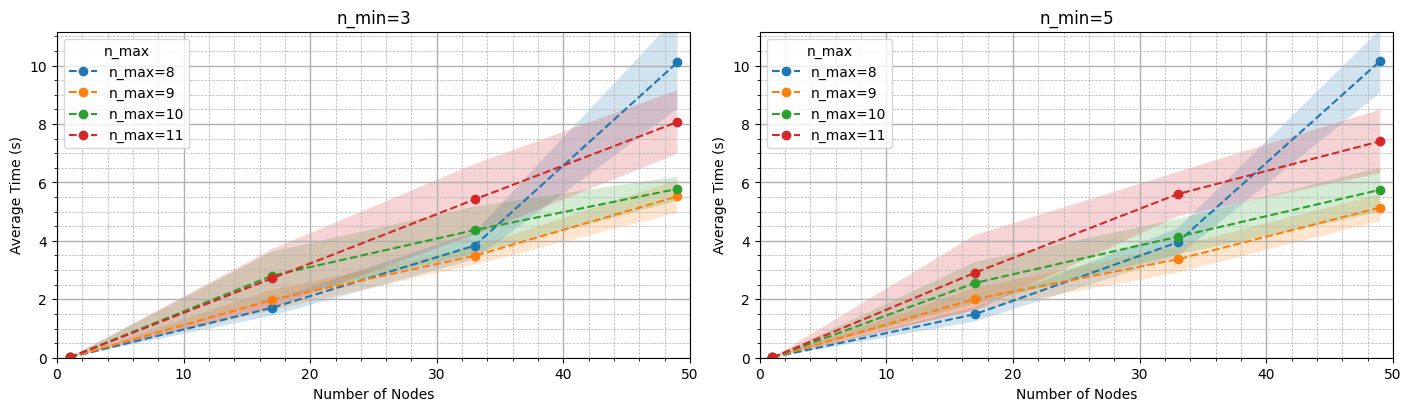

In [297]:
dfs_out = []
for key, value in selected_sfs.items():
    value["sf"].show_stats(compact=True)

    # config for > 70 max nodes
    # value["result_df"] = run_association_simulations(value["sf"], splits_nodes=5, range_n_min=[1, 3, 5, 7], range_n_max=range(9, 14), number_of_runs=1000, tag=key) # 1 run ~= 30s
    # value["result_df"] = run_association_simulations(value["sf"], splits_nodes=3, range_n_min=[3, 5, 7], range_n_max=range(9, 11), number_of_runs=20)

    # config for ~ 50 max nodes
    value["result_df"] = run_association_simulations(value["sf"], splits_nodes=3, range_n_min=[3, 5], range_n_max=range(8, 12), number_of_runs=20, tag=key)

    # config for < 30 max nodes
    # value["result_df"] = run_association_simulations(value["sf"], splits_nodes=3, range_n_min=[3, 5], range_n_max=range(7, 12), number_of_runs=100, tag=key)

    plot_association_simulation_results_grid(value["result_df"], columns=2, tag=key)
    print("=====================================================================\n\n")

In [118]:
# sf = sf_configs.slotframes[0] # a good slotframe, with 101 nodes. n_max of 7 or 8 is unusable
# # sf = sf_configs.slotframes[-1] # a very simple slotframe

# sf.show_stats(compact=True)

# df = run_association_simulations(sf, splits_nodes=5, range_backoff=range(9, 15), number_of_runs=10)
# plot_association_simulation_results(df)

# Scratchpad

In [262]:
sf = sf_configs.slotframes[0].show_stats()

Latency(sf).show_stats()
OTAP(sf).show_stats(size=30_000)
Association(sf).show_stats()

Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

Latency worst case:

- downlink/uplink reply:            269.19 ms
- uplink/downlink reply (estimate): 1386.45 ms

OTAP update:

- Image size: 30 kB
- Duration: 3.05 s

- Packets: 235
- swarmit_chunk_size: 128 B
- Needed slotframes: 11

Association time:

- Max time no collisions (estimate):            2772.9 ms

In [263]:
sf = copy.deepcopy(sf_configs.slotframes[0])

n_gateways = 10
n_nodes_per_gw = 1 #round(sf.max_nodes() / 1)

[sf.assign_next_available_uplink_slot(i, after=sf.max_nodes()/2+9) for i in range(0, n_nodes_per_gw)]

text = [Text("")] # just because otherwise there's an extra space I can't fix
text += [
    Text.assemble(
        sf.repr_nice(compact=True, start_slot=(0 if i == 0 else random.randint(0, len(sf.slots) - 1))),
        "\n\n"
    )
    for i in range(n_gateways)
]
Console().print(*text, end="\n", soft_wrap=True)

↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU

 UUUUUU↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓U

 UUUU↓UUUUUUU↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓

 UUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUU

 UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU↓↓↓S↓

 U↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUU

 UUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUUU↓↓↓S↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUU

 UU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓UUUUUS↓UUUU↓[1;33;

# Simulation

In [264]:
# simple slotframe
sf_simple = Slotframe.build_blocks2("SDUUU", 3, "B", force_prime="U")

sf_simple.show()
sf_simple.slot_count, sf_simple.duration, sf_simple.max_nodes()

[B↓[S][D↓[U][U][U][S][D↓[U][U][U][S][D↓[U][U][U][U]

(17, 34.41, 10)

In [265]:
# good slotframe
sf_good = Slotframe.build_blocks2("SDUUUUDUUUUU", 11, "BBB") # max 101 nodes
# sf_good = Slotframe.build_blocks2("SDUUUDUUU", 12, "BBB") # max 74 nodes

sf_good.show()
sf_good.slot_count, sf_good.duration, sf_good.max_nodes()

# sf_good

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

(137, 277.29, 101)

In [266]:
@dataclass
class Packet:
    dst: int
    src: int = None
    id: int = None
    enqueued_at: float = None # timestamp when the packet was enqueued (to calculate latency)

    type_app: str = "status" # "status", "cmd", "ack"
    needs_ack: bool = False
    # ack_to: int = None # the packet id that this packet is an ack to

    original_enqueued_at: float = None # timestamp when the packet was first enqueued (to calculate latency of acks)

    def __post_init__(self):
        self.id = random.randint(0, 1_000_000)

    def __repr__(self):
        enqueued_at_rounded = round(self.enqueued_at, 2) if self.enqueued_at is not None else None
        return f"Packet(dst={self.dst}, src={self.src}, id={self.id}, type_app={self.type_app}, enqueued_at={enqueued_at_rounded})"

    def to_dict(self):
        return {k: v for k, v in asdict(self).items() if v is not None}

@dataclass
class Node:
    id: int
    sf: Slotframe = field(repr=False)
    status: str = "idle"  # idle, scanning, got_beacon, sent_join_request, joined

    n_min: int = 0 # minimum exponent for the backoff
    n_max: int = 7 # maximum exponent for the backoff

    tx_status_period: int = 1000 # ms, how often the node sends a status packet

    tx_needs_ack_period: int = None # ms, how often the node sends a packet that needs an ack
    last_tx_needs_ack_packet_ts: float = 0 # timestamp when the last packet that needs an ack was sent

    backoff_n: int = None # exponential backoff counter, increases after a collision until it reaches n_max
    backoff_random_time: int = 0 # random number of slots to wait before trying to join again, decremented each slot

    assigned_slot: int = None

    tx_queue: List[Packet] = field(default_factory=list)
    tx_queue_max_len: int = 5

    last_status_packet_ts: float = 0 # timestamp when the last status packet was sent

    # right now unused. remove?
    started_scanning_ts: float = None
    sent_join_request_ts: float = None
    joined_ts: float = None

    def __post_init__(self):
        self.downlink_stats = []

    def run_common_logic(self):
        self.verify_backoff_wait()

    def register_scanning(self, ts):
        self.status = "scanning"
        self.started_scanning_ts = ts

    def rx_beacon(self):
        self.status = "got_beacon"

    def tx_join_request(self, ts):
        self.status = "sent_join_request"
        self.sent_join_request_ts = ts

    def rx_join_response(self, ts):
        self.status = "joined"
        self.joined_ts = ts
        self.reset_backoff()  # Reset backoff after a successful join
        self.last_tx_needs_ack_packet_ts = ts # starts counting when node joins

    def rx_downlink(self, packet, slot):
        # print(f"~    Node {self.id} received downlink at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.enqueued_at, 2)} ms), {packet}")
        self.downlink_stats.append({
            "dst": packet.dst,
            "tx_ts": packet.enqueued_at,
            "rx_ts": slot.end,
            "needs_ack": packet.needs_ack,
            "is_ack": packet.type_app == "ack",
            "latency": round(slot.end - packet.enqueued_at, 2),
            "roundtrip_latency": round(slot.end - packet.original_enqueued_at, 2) if packet.type_app == "ack" else None,
            # "packet": packet.to_dict(),
        })
        if packet.needs_ack:
            reply = Packet(dst=packet.src, src=self.id, enqueued_at=round(slot.end, 2), type_app="ack", original_enqueued_at=packet.enqueued_at)
            # queue may be full, so try to pop the oldest packet whose type is status
            if len(self.tx_queue) >= self.tx_queue_max_len:
                for i, p in enumerate(self.tx_queue):
                    if p.type_app == "status":
                        self.tx_queue.pop(i)
                        break
            # now, if there is space, append the ack to the end of the queue
            if len(self.tx_queue) < self.tx_queue_max_len:
                self.tx_queue.append(reply)
            # else:
                # print("node queue is full for ack")

    def ready_to_tx(self):
        """Peek at the next packet to transmit."""
        if len(self.tx_queue) > 0:
            return self.tx_queue[0]

    def tx_uplink(self):
        """Transmit the next packet."""
        if len(self.tx_queue) > 0:
            return self.tx_queue.pop(0)

    def should_try_to_join(self):
        """Check if the node should try to join the network."""
        return self.status == "got_beacon" and self.backoff_random_time == 0

    def enqueue_override_old_status(self, packet):
        """Append a packet to the queue, overriding an old status packet if needed."""
        # queue may be full, so try to pop the oldest packet whose type is status
        if len(self.tx_queue) >= self.tx_queue_max_len:
            for i, p in enumerate(self.tx_queue):
                if p.type_app == "status":
                    self.tx_queue.pop(i)
                    break
        # now, if there is space, append the ack to the end of the queue
        if len(self.tx_queue) < self.tx_queue_max_len:
            self.tx_queue.append(packet)

    def maybe_enqueue_tx_packet(self, slot):
        """Enqueue a packet, but only every tx_status_period or tx_needs_ack_period ms."""
        if \
           self.tx_needs_ack_period\
           and self.status == "joined"\
           and slot.start - self.last_tx_needs_ack_packet_ts >= self.tx_needs_ack_period:
            packet = Packet(dst=GATEWAY_ID, src=self.id, enqueued_at=round(slot.start, 2), type_app="robot-request", needs_ack=True)

            self.enqueue_override_old_status(packet)

            self.last_tx_needs_ack_packet_ts = slot.start # reset the timer for next time a batch of needs-ack packets are sent
        elif\
          self.status == "joined" and\
          slot.start - self.last_status_packet_ts >= self.tx_status_period and\
          len(self.tx_queue) < self.tx_queue_max_len:
            packet = Packet(dst=GATEWAY_ID, src=self.id, enqueued_at=round(slot.start, 2), type_app="status")
            self.tx_queue.append(packet)
            # print(f"~  Node enqueued uplink at {slot.id} = {round(slot.start, 2)} -- {packet}")
            self.last_status_packet_ts = slot.start
            return packet

    # backoff functions
    def verify_backoff_wait(self):
        if self.backoff_random_time > 0:
            self.backoff_random_time -= 1

    def register_collision(self):
        if self.backoff_n is None:
            self.backoff_n = self.n_min
        else:
            # increment the n in [0, 2^n - 1], but only if n is less than the max
            self.backoff_n = min(self.backoff_n + 1, self.n_max)
         # choose a random number from [0, 2^n - 1]
        self.backoff_random_time = random.randint(0, 2 ** self.backoff_n - 1)

    def reset_backoff(self):
        self.backoff_n = None
        self.backoff_random_time = 0

    def __repr__(self):
        return f"Node(status={self.status}, backoff_n={self.backoff_n})"
    
    def repr_nice(self, compact=False):
        abbrev = {
            "idle": "I",
            "scanning": "S",
            "got_beacon": "B",
            "sent_join_request": "R",
            "joined": "J",
        }[self.status]
        color = "red"
        bg_color = "white"
        if self.status == "joined":
            color = "green"
            if self.assigned_slot is not None:
                bg_color = "yellow"
        return rich.text.Text(abbrev, style=f'bold {color} on {bg_color}')


GATEWAY_ID = 255
@dataclass
class Gateway:
    sf: Slotframe = field(repr=False)
    joined_nodes: List[Node] = field(default_factory=list)
    id: int = GATEWAY_ID
    tx_queue: List[Packet] = field(default_factory=list)
    tx_queue_max_len: int = 10
    tx_probability: float = 0.1

    tx_cmd_ack_period: int = None # ms, how often the gateway sends a command that needs an ack. None means never
    last_cmd_ack_packet_ts: int = 0 # timestamp when the last packet that needs an ack was sent

    def __post_init__(self):
        self.tx_queue_max_len = sf.max_nodes()
        self.uplink_stats = []

    def accept_join(self, node, slot):
        self.joined_nodes.append(node)
    
    def maybe_enqueue_tx(self, slot):
        """Enqueue one or more tx's for nodes.

        - if it is time to send a batch of packets that need ack
        - or if tx_probability allows sending a no-ack packet
        """
        #    and len(self.joined_nodes) == self.sf.max_nodes()\
        if \
           self.tx_cmd_ack_period\
           and slot.start - self.last_cmd_ack_packet_ts >= self.tx_cmd_ack_period:
            self.tx_queue = [] # clear the queue, ignoring any previously scheduled probabilistic packet
            [
                self.tx_queue.append(Packet(dst=node.id, enqueued_at=round(slot.start, 2), type_app="cmd", needs_ack=True))
                for node in self.joined_nodes
            ]
            self.last_cmd_ack_packet_ts = slot.start # reset the timer for next time a batch of needs-ack packets are sent
        elif \
           len(self.joined_nodes) > 0 and\
           len(self.tx_queue) < self.tx_queue_max_len and\
           random.random() < self.tx_probability:
            node = random.choice(self.joined_nodes)
            packet = Packet(dst=node.id, enqueued_at=round(slot.start, 2), type_app="cmd")
            self.tx_queue.append(packet)
            # print(f"~  Gateway enqueued downlink at {slot.id} = {round(slot.start, 2)} -- {packet}")
            return packet

    def rx_uplink(self, packet, slot):
        # print(f"~    Gateway received uplink at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.enqueued_at, 2)} ms), {packet}")
        self.uplink_stats.append({
            "src": packet.src,
            "tx_ts": packet.enqueued_at,
            "rx_ts": slot.end,
            "needs_ack": packet.needs_ack,
            "is_ack": packet.type_app == "ack",
            "latency": round(slot.end - packet.enqueued_at, 2),
            "roundtrip_latency": round(slot.end - packet.original_enqueued_at, 2) if packet.type_app == "ack" else None,
            # "packet": packet.to_dict(),
        })
        if packet.needs_ack:
            reply = Packet(dst=packet.src, src=self.id, enqueued_at=round(slot.end, 2), type_app="ack", original_enqueued_at=packet.enqueued_at)
            # append if queue is not full (will be dropped if full)
            # should be fine for cases where the gateway is not too busy, i.e., tx_probability is low
            if len(self.tx_queue) < self.tx_queue_max_len:
                self.tx_queue.append(reply)
            # else:
                # print("gateway queue is full for ack")
        # if packet.type_app == "ack":
        #     print(f"~    Gateway received ack at {slot.id} = {round(slot.end, 2)} (latency was {round(slot.end - packet.original_enqueued_at, 2)} ms), {packet}")

    def ready_to_tx(self):
        """Peek at the next packet to transmit."""
        if len(self.tx_queue) > 0:
            return self.tx_queue[0]

    def tx_downlink(self):
        """Transmit the next packet."""
        if len(self.tx_queue) > 0:
            return self.tx_queue.pop(0)


@dataclass
class SimConfig:
    sf: Slotframe
    nodes_setting: Union[int, str] = "min" # "min", "avg", "max", or number of nodes
    debug: bool = False
    n_min: int = 0
    n_max: int = 7

    operation_duration_ms: int = 1_000
    gateway_tx_probability: float = 0.1 # probability of the gateway transmitting a packet in a slot
    node_tx_status_period: int = 1000 # ms, how often the node sends a status packet

    # ms, how often the node sends a packet that needs an ack
    # for example, if a node needs to ask some data from the infrastructure
    node_tx_needs_ack_period: int = None

    # ms, how often the gateway sends a command that needs an ack
    # for example, when the gateway sends a "go to location x,y" to all nodes at once
    gateway_tx_cmd_ack_period: int = None

    node_can_tx_as_soon_as_joined: bool = False # whether the node should start transmitting as soon as it joined, or wait until all nodes joined

    def __post_init__(self):
        # make sure the sf is copied (not referenced)
        self.sf = Slotframe.build(self.sf.as_raw_abbreviations())
        self.node_tx_status_period = round(self.node_tx_status_period)
        if self.node_tx_needs_ack_period:
            self.node_tx_needs_ack_period = round(self.node_tx_needs_ack_period)
        if self.gateway_tx_cmd_ack_period:
            self.gateway_tx_cmd_ack_period = round(self.gateway_tx_cmd_ack_period)

    @property
    def n_nodes(self):
        if self.nodes_setting == "min":
            return 1
        elif self.nodes_setting == "max":
            return self.sf.max_nodes()
        elif self.nodes_setting == "avg":
            return math.ceil(self.sf.max_nodes() / 2)
        elif isinstance(self.nodes_setting, int):
            return self.nodes_setting
        else:
            raise ValueError(f"Unknown nodes setting: {self.nodes_setting}")

    def __repr__(self):
        return f"SimConfig(n_nodes={self.n_nodes})"

@dataclass
class OpenSwarmNetworkSimulation:
    """
    We want to simulate:
    - executing the slotframes in sequence, with e.g. 1 or MAX nodes
    - the association of nodes
    """
    config: SimConfig
    gw: Gateway = field(default=None, repr=False)
    nodes: List[Node] = field(default_factory=list, repr=False)
    executed_slots: any = field(default_factory=list, repr=False)

    complete_join_slot = None

    def __post_init__(self):
        self.gateway = Gateway(
            self.config.sf,
            tx_probability=self.config.gateway_tx_probability,
            tx_cmd_ack_period=self.config.gateway_tx_cmd_ack_period
        )
        self.nodes = [
            Node(
                i, self.config.sf,
                n_min=self.config.n_min, n_max=self.config.n_max,
                tx_status_period=self.config.node_tx_status_period,
                tx_needs_ack_period=self.config.node_tx_needs_ack_period
            )
            for i in range(self.config.n_nodes)
        ]
        self.sf_index = 0
        self.complete_join_slot = None

    def run(self):
        console = Console()
        [node.register_scanning(0) for node in self.nodes]
        while self.at_join_phase() or self.at_operational_phase():
            # print(f"asn {self.current_slot.asn}")
            had_new_join = False # for debugging

            [node.run_common_logic() for node in self.nodes]

            # ==== enqueue packets for transmission, for joined nodes, given configured conditions ====
            if self.nodes_can_already_send_data():
                self.gateway.maybe_enqueue_tx(slot=self.current_slot)

            # ==== enqueue status packets for transmission, if it is already time to do so (only if node is joined) ====
            if self.nodes_can_already_send_data():
                [
                    node.maybe_enqueue_tx_packet(slot=self.current_slot)
                    for node in self.nodes
                ]

            # execute based on the slot type
            if self.current_slot.abbrev == "B":
                [node.rx_beacon() for node in self.nodes if node.status == "scanning"]
            elif self.current_slot.abbrev == "S":
                # check for collisions (whether multiple nodes want to join at the same time)
                nodes_wanting_to_join = [node for node in self.nodes if node.should_try_to_join()]
                if len(nodes_wanting_to_join) == 1:
                    node = nodes_wanting_to_join[0]
                    node.tx_join_request(self.current_slot.start)
                    self.gateway.accept_join(node, self.current_slot)
                if len(nodes_wanting_to_join) > 0:
                    [node.register_collision() for node in nodes_wanting_to_join]
            elif self.current_slot.abbrev == "D":
                # get node that sent a join request, if any
                node = next((node for node in self.nodes if node.status == "sent_join_request"), None)
                if node:
                    node.rx_join_response(self.current_slot.start)
                    self.config.sf.assign_next_available_uplink_slot(node.id)
                    had_new_join = True
                else:
                    if self.nodes_can_already_send_data():
                        packet = self.gateway.ready_to_tx()
                        if packet:
                            node = next((node for node in self.nodes if node.id == packet.dst), None)
                            if not node:
                                raise ValueError(f"Node with address {packet.dst} not found")
                            self.gateway.tx_downlink()
                            node.rx_downlink(packet, self.current_slot)
            elif self.current_slot.abbrev == "U" and self.nodes_can_already_send_data():
                if self.has_scheduled_uptime():
                    # get assigned node
                    node = next((node for node in self.nodes if node.id == self.current_slot.assigned_node_id), None)
                    if node:
                        packet = node.ready_to_tx()
                        if packet:
                            node.tx_uplink()
                            self.gateway.rx_uplink(packet, self.current_slot)

            # ==== check if this slot marks the end of the join phase ====
            if had_new_join and self.complete_join_slot is None and self.all_nodes_joined():
                self.complete_join_slot = Slot(type=self.current_slot.type, start=self.current_slot.start, asn=self.current_slot.asn)
                # print(f"{self.complete_join_slot.repr_nice()}, all nodes joined")

            wrapped = self.advance_slot()

            # ==== for debugging =====
            if self.config.debug:
                if self.at_join_phase() and had_new_join:
                    clear_output(wait=True) # Clear previous output and reprint in the same cell
                    console.print(self.config.sf.repr_nice(True), soft_wrap=True)
                    time.sleep(0.005)
                elif self.at_operational_phase() and self.current_slot.asn % 1000 == 0:
                    clear_output(wait=True) # Clear previous output and reprint in the same cell
                    console.print(self.config.sf.repr_nice(True), soft_wrap=True)
                    console.print(f"Operation phase timestamp: {self.time_spent_at_operational_phase}")
                    time.sleep(0.005)

        return self

    def has_scheduled_uptime(self):
        return self.current_slot.assigned_node_id is not None

    def at_join_phase(self):
        return self.complete_join_slot is None

    @property
    def time_spent_at_operational_phase(self):
        n_executed_op_slots = self.current_slot.asn - self.complete_join_slot.asn
        return round(n_executed_op_slots * self.current_slot.duration, 2)

    def at_operational_phase(self):
        if self.at_join_phase():
            return False
        return self.time_spent_at_operational_phase <= self.config.operation_duration_ms

    def nodes_can_already_send_data(self):
        return self.at_operational_phase() or self.config.node_can_tx_as_soon_as_joined

    def all_nodes_joined(self):
        return all([node.status == "joined" for node in self.nodes])

    @property
    def current_slot(self):
        return self.config.sf.current

    @property
    def iterations(self):
        return len(self.executed_slots)

    @property
    def duration_complete_join(self):
        return self.complete_join_slot.start

    def advance_slot(self):
        self.executed_slots.append(self.current_slot)
        return self.config.sf.advance_slot()

    # statistics
    def get_gateway_uplink_stats_df(self):
        return pd.DataFrame(self.gateway.uplink_stats)

    def get_nodes_downlink_stats_df(self):
        nested_stats = [n.downlink_stats for n in self.nodes]
        flat_stats = [stat for stats in nested_stats for stat in stats]
        return pd.DataFrame(flat_stats)

    def save_stats(self, tag="example"):
        self.get_gateway_uplink_stats_df().to_csv(f"csv/gateway_uplink_stats_{tag}.csv")
        self.get_nodes_downlink_stats_df().to_csv(f"csv/nodes_downlink_stats_{tag}.csv")
        return

    # show it
    def show(self):
        console = Console()
        # console.print("gateway", self.gateway.uplink_stats[:10])
        # console.print("gateway ack", [stat for stat in self.gateway.uplink_stats if stat["is_ack"]][:10])
        # console.print("nodes", [n.downlink_stats for n in self.nodes[:2]])
        # console.print("nodes ack", [[stat for stat in n.downlink_stats if stat["is_ack"]] for n in self.nodes[:2]])
        console.print(f"""\
Finished simulation with {len(self.nodes)} nodes:

==== Association phase ====
- Done after {self.duration_complete_join/1000:.2f} s (asn {self.complete_join_slot.asn})
- Slots in frame: {self.config.sf.slot_count}    {self.config.sf.count_slots_per_type()}
- Association slot: {self.current_slot}
- Association ASN: {self.current_slot.asn}

==== Operational phase ====
- Ran from {self.complete_join_slot.start/1000:.2f} s to {self.current_slot.start/1000:.2f} s (asn {self.current_slot.asn})

==== Gateway ====
- Received uplink count: {len(self.gateway.uplink_stats)}
- Average latency: {np.mean([stat["latency"] for stat in self.gateway.uplink_stats]):.2f} ms (±{np.std([stat["latency"] for stat in self.gateway.uplink_stats]):.2f})

==== Nodes ====
- Received downlink count: {sum([len(node.downlink_stats) for node in self.nodes])}
- Per-node downlink count: {[len(node.downlink_stats) for node in self.nodes]}
- Average latency: {np.mean([stat["latency"] for node in self.nodes for stat in node.downlink_stats]):.2f} ms (±{np.std([stat["latency"] for node in self.nodes for stat in node.downlink_stats]):.2f})


==== The used TSCH schedule is: ====\
""")
        # console.print(self.config.sf.repr_nice(compact=False))
        self.config.sf.show_stats(compact=False)
        return self

    def __repr__(self):
        return f"OpenSwarmNetworkSimulation(config={self.config}, stopped_at={self.executed_slots[-1]})"

sim_config = SimConfig(
    nodes_setting="max",

    # sf=sf_simple, operation_duration_ms=sf_simple.duration * 30,
    # node_tx_status_period=sf_simple.duration * 1.1, node_tx_needs_ack_period=None,#sf_simple.duration * 6,
    # gateway_tx_probability=0.1, gateway_tx_cmd_ack_period=sf_simple.duration * 7,

    sf=sf_good, operation_duration_ms=30_000 * 1,
    node_tx_status_period=sf_good.duration * 1.1, node_tx_needs_ack_period=None,#5000,
    gateway_tx_probability=0.1, gateway_tx_cmd_ack_period=None,#15_000,

    node_can_tx_as_soon_as_joined=True,
    n_min=3, n_max=9, # association backoff parameters
    # debug=True,
)
sim = OpenSwarmNetworkSimulation(sim_config).run().show()
# sim.save_stats(tag="example")
display(sim.get_gateway_uplink_stats_df().dropna(subset=['roundtrip_latency']).head())
display(sim.get_nodes_downlink_stats_df().dropna(subset=['roundtrip_latency']).head())

Finished simulation with 101 nodes:

==== Association phase ====
- Done after 20.32 s (asn 10041)
- Slots in frame: 137    {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Association slot: Slot(U, 67, duration=2.02, asn=24864, start=50325.10)
- Association ASN: 24864

==== Operational phase ====
- Ran from 20.32 s to 50.33 s (asn 24864)

==== Gateway ====
- Received uplink count: 12167
- Average latency: 139.29 ms (±80.03)

==== Nodes ====
- Received downlink count: 2471
- Per-node downlink count: [6, 23, 10, 57, 53, 23, 18, 26, 17, 24, 16, 20, 11, 17, 17, 10, 16, 27, 19, 11, 18, 54, 
13, 101, 28, 20, 14, 21, 73, 22, 10, 12, 12, 18, 17, 11, 66, 27, 10, 10, 21, 21, 66, 52, 14, 19, 24, 17, 20, 22, 
16, 38, 11, 54, 41, 25, 22, 26, 19, 35, 17, 13, 22, 15, 43, 12, 14, 18, 19, 22, 16, 34, 26, 38, 44, 18, 20, 15, 17,
20, 16, 19, 17, 47, 11, 15, 30, 20, 17, 17, 23, 30, 28, 19, 20, 17, 55, 20, 25, 18, 23]
- Average latency: 19.53 ms (±17.75)


==== The used TSCH schedule is: ====

Slotframe with 137 slots of 2.02 ms each (total 277.29 ms):

[B↓[B↓[B↓[S][D↓[23][28][53][3][D↓[21][36][42][96][43][S][D↓[51][4][54][83][D↓[74][59][86][64][73][S][D↓[17][37][9][
87][D↓[24][97][45][72][46][S][D↓[1][25][7][41][D↓[55][68][98][26][29][S][D↓[71][52][57][48][D↓[8][69][62][6][82][S]
[D↓[63][58][90][92][D↓[81][94][12][14][91][S][D↓[10][20][40][80][D↓[30][79][11][61][15][S][D↓[70][76][5][93][D↓[16]
[66][95][27][18][S][D↓[32][44][75][49][D↓[77][89][33][88][99][S][D↓[60][56][50][67][D↓[2][38][22][85][34][S][D↓[13]
[100][35][0][D↓[78][47][65][31][19][84][39]

- Max nodes: 101 (number of data-up slots)

- MTU per slot: 256 B
- Slot duration: 2.02 ms (TOA: 1.02 ms, PAD: 1 ms)
- Number of slots per type: {'beacon': 3, 'data-shared-up': 11, 'data-down': 22, 'data-up': 101}
- Ratio of data-up to data-down slots: 4.59

,src,tx_ts,rx_ts,needs_ack,is_ack,latency,roundtrip_latency


,dst,tx_ts,rx_ts,needs_ack,is_ack,latency,roundtrip_latency


In [ ]:
def plot_latency_distribution_side_by_side(uplink_df, downlink_df, uplink_name, downlink_name, node_needs_ack_period, gateway_needs_ack_period, tag=""):
    """
    Plot the latency distribution of uplink and downlink DataFrames side by side.
    Optionally includes "roundtrip_latency" in the plot if with_roundtrip=True.

    Args:
    - uplink_df: DataFrame containing the uplink latency data.
    - downlink_df: DataFrame containing the downlink latency data.
    - uplink_name: Title for the uplink plot.
    - downlink_name: Title for the downlink plot.
    - tag: Optional tag for saving the figure.
    """
    columns = 2
    if "roundtrip_latency" in uplink_df.columns:
        columns += 1
    if "roundtrip_latency" in downlink_df.columns:
        columns += 1
    fig, axes = plt.subplots(1, columns, figsize=(16, 5), constrained_layout=True)

    # Uplink plot
    sns.histplot(uplink_df["latency"], bins=15, kde=True, ax=axes[0], color='blue', edgecolor='black', alpha=0.7, label='Latency (one way)')
    axes[0].set_xlabel('Latency (ms)')
    axes[0].set_ylabel('Packet Count')
    axes[0].set_title(f'Latency for {uplink_name}')
    axes[0].grid(True, which='major', linestyle='--', linewidth=0.5)
    axes[0].legend()

    # Downlink plot
    sns.histplot(downlink_df["latency"], bins=15, kde=True, ax=axes[1], color='blue', edgecolor='black', alpha=0.7, label='Latency (one way)')
    axes[1].set_xlabel('Latency (ms)')
    axes[1].set_ylabel('Packet Count')
    axes[1].set_title(f'Latency for {downlink_name}')
    axes[1].grid(True, which='major', linestyle='--', linewidth=0.5)
    axes[1].legend()

    # Uplink roundtrip plot
    if "roundtrip_latency" in uplink_df.columns:
        sns.histplot(uplink_df["roundtrip_latency"], bins=15, kde=True, ax=axes[2], color='green', edgecolor='black', alpha=0.7, label='Latency (roundtrip)')
        axes[2].set_xlabel('Latency (ms)')
        axes[2].set_ylabel('Packet Count')
        axes[2].set_title(f'Roundtrip Latency at Gateway \n gateway_needs_ack_period = {gateway_needs_ack_period} ms')
        axes[2].grid(True, which='major', linestyle='--', linewidth=0.5)
        axes[2].legend()

        # # have max y be the same as uplink plot
        # axes[2].set_ylim(axes[0].get_ylim())
    
    if "roundtrip_latency" in downlink_df.columns:
        sns.histplot(downlink_df["roundtrip_latency"], bins=15, kde=True, ax=axes[3], color='green', edgecolor='black', alpha=0.7, label='Latency (roundtrip)')
        axes[3].set_xlabel('Latency (ms)')
        axes[3].set_ylabel('Packet Count')
        axes[3].set_title(f'Roundtrip Latency at DotBot \n node_needs_ack_period = {node_needs_ack_period} ms')
        axes[3].grid(True, which='major', linestyle='--', linewidth=0.5)
        axes[3].legend()

        # # have max y be the same as downlink plot
        # axes[3].set_ylim(axes[1].get_ylim())

    # Save the figure if a tag is provided
    if tag:
        plt.savefig(f"fig/latency-{tag}.pdf")
    plt.show()

plot_latency_distribution_side_by_side(
    uplink_df=sim.get_gateway_uplink_stats_df(),
    downlink_df=sim.get_nodes_downlink_stats_df(),
    uplink_name=f"uplink with: \n tx_status = {sim.config.node_tx_status_period} ms \n node_needs_ack_period = {sim.config.node_tx_needs_ack_period} ms",
    downlink_name=f"downlink with: \n tx_probability = {round(sim.config.gateway_tx_probability * 100)}% \n gateway_needs_ack_period = {sim.config.gateway_tx_cmd_ack_period}",
    tag="example_uplink_downlink",
    node_needs_ack_period=sim.config.node_tx_needs_ack_period,
    gateway_needs_ack_period=sim.config.gateway_tx_cmd_ack_period,
)


==== Running with node_tx_period=None, gateway_tx_period=None ====
==== Running with node_tx_period=None, gateway_tx_period=25000 ====
==== Running with node_tx_period=5000, gateway_tx_period=None ====
==== Running with node_tx_period=5000, gateway_tx_period=25000 ====


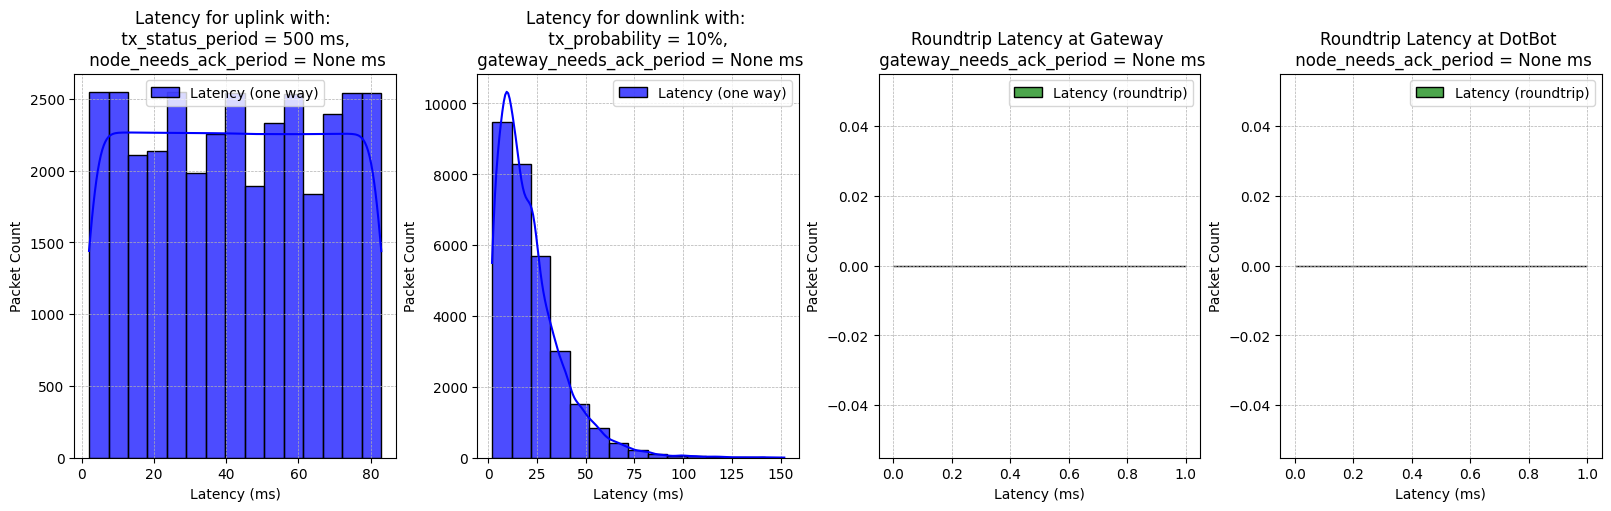

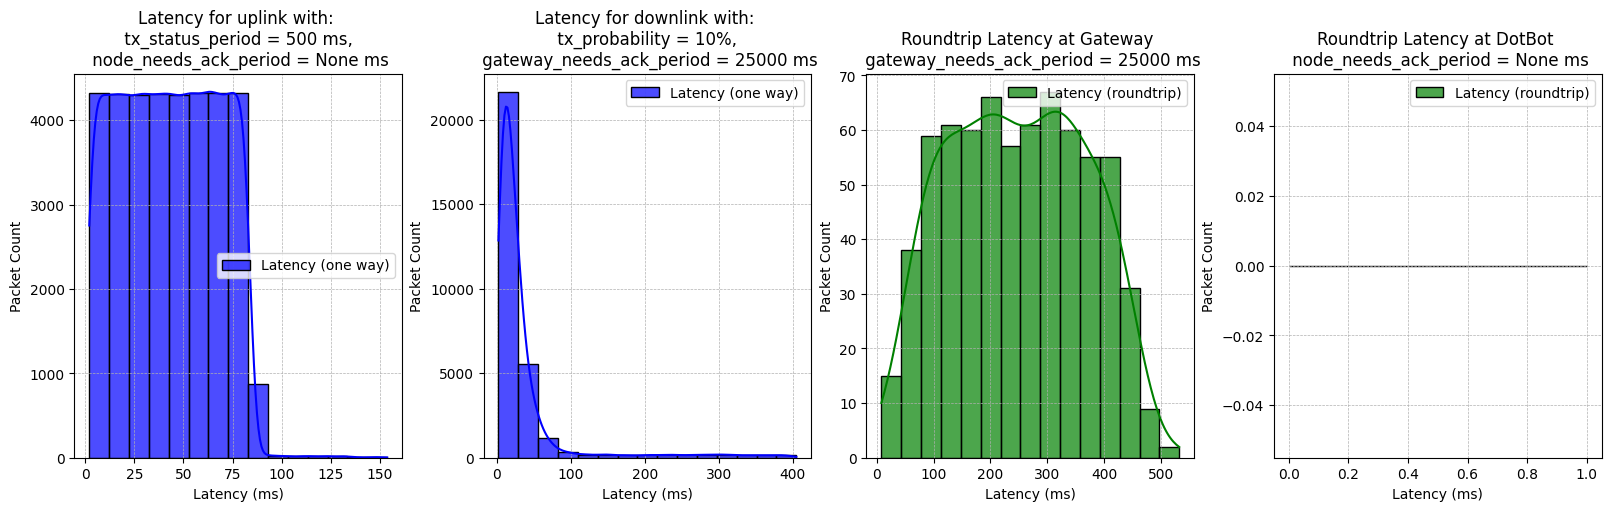

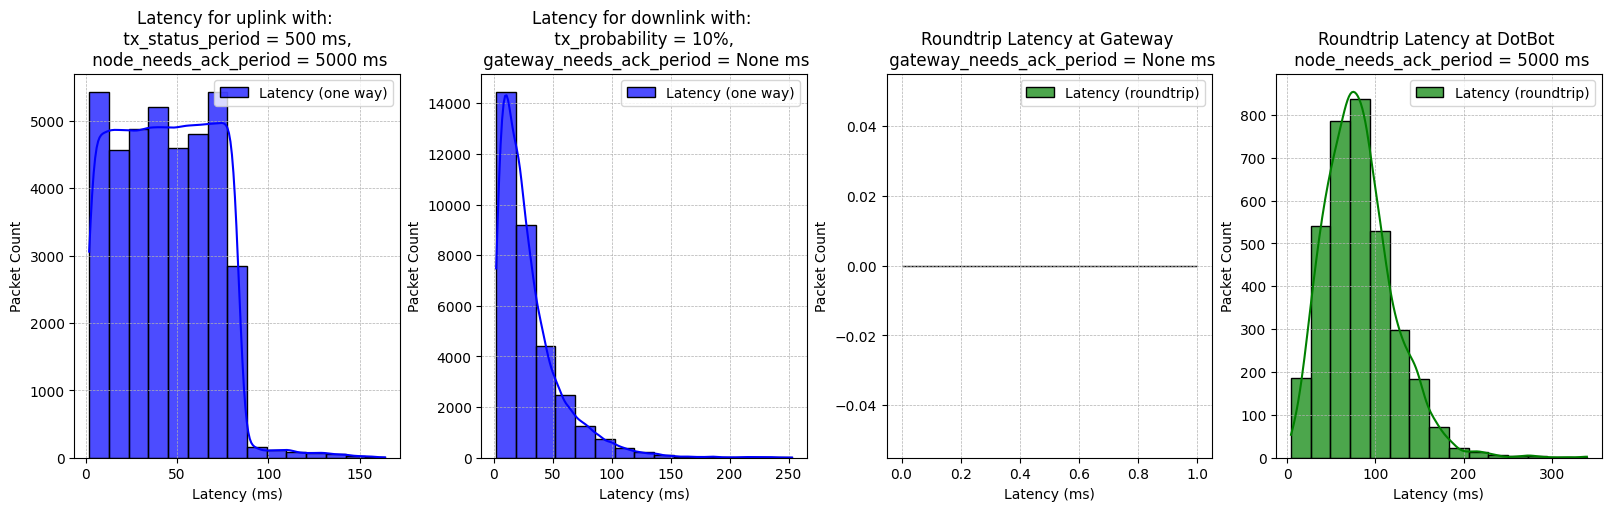

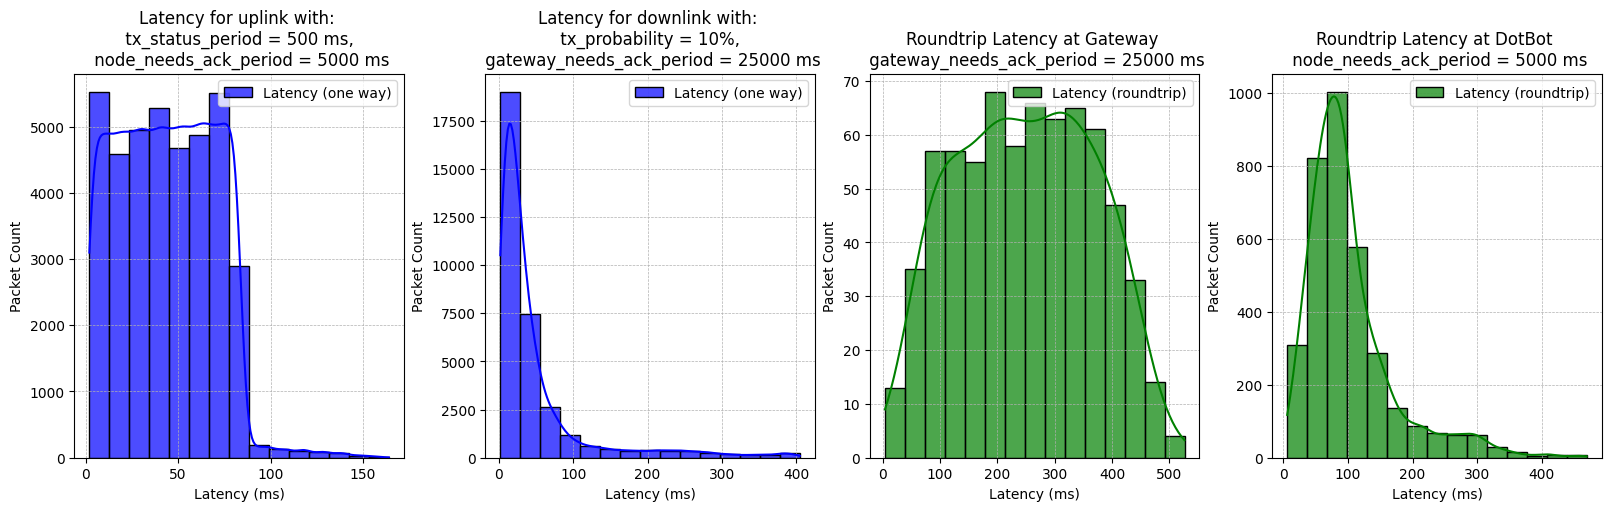

In [302]:
node_tx_periods = [None, 5000]
gateway_tx_periods = [None, 25000]

tx_status_period = 500 #round(sf_good.duration * 1.1)
tx_probability = 0.1

# sf = sf_good
sf = sf_configs.slotframes[3]

results_latency = []

for node_tx_period in node_tx_periods:
    for gateway_tx_period in gateway_tx_periods:
        print(f"==== Running with node_tx_period={node_tx_period}, gateway_tx_period={gateway_tx_period} ====")

        sim_config = SimConfig(
            nodes_setting="max",

            sf=sf, operation_duration_ms=60_000 * 10,
            node_tx_status_period=tx_status_period, node_tx_needs_ack_period=node_tx_period,
            gateway_tx_probability=tx_probability, gateway_tx_cmd_ack_period=gateway_tx_period,

            node_can_tx_as_soon_as_joined=True,
            n_min=5, n_max=9, # association backoff parameters
            debug=False,
        )

        sim = OpenSwarmNetworkSimulation(sim_config)
        sim.run()#.show()
        # sim.save_stats(tag=f"sf_101_n-{node_tx_period}_g-{gateway_tx_period}")
        sim.save_stats(tag=f"sf_{sf.max_nodes()}_n-{node_tx_period}_g-{gateway_tx_period}")

        results_latency.append({
            "node_tx_period": node_tx_period,
            "gateway_tx_period": gateway_tx_period,
            "gateway_uplink": sim.get_gateway_uplink_stats_df(),
            "nodes_downlink": sim.get_nodes_downlink_stats_df(),
        })

for res in results_latency:
    plot_latency_distribution_side_by_side(
        uplink_df=res["gateway_uplink"],
        downlink_df=res["nodes_downlink"],
        uplink_name=f"uplink with: \n tx_status_period = {tx_status_period} ms, \n node_needs_ack_period = {res['node_tx_period']} ms",
        downlink_name=f"downlink with: \n tx_probability = {round(tx_probability * 100)}%, \n gateway_needs_ack_period = {res['gateway_tx_period']} ms",
        tag=f"sf_{sf.max_nodes()}-ns_{tx_status_period}-n_{res['node_tx_period']}-gp_{tx_probability}-g_{res['gateway_tx_period']}",
        node_needs_ack_period=res['node_tx_period'],
        gateway_needs_ack_period=res['gateway_tx_period'],
    )


For this slotframe configuration:


↓↓↓S↓UUUS↓UUUS↓UUUS↓UUUS↓UUUU

Running:
  n_nodes = 1    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 6    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 11    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  
  n_nodes = 16    n_min = 3 (n_max = 9 10 11 )  4 (n_max = 9 10 11 )  



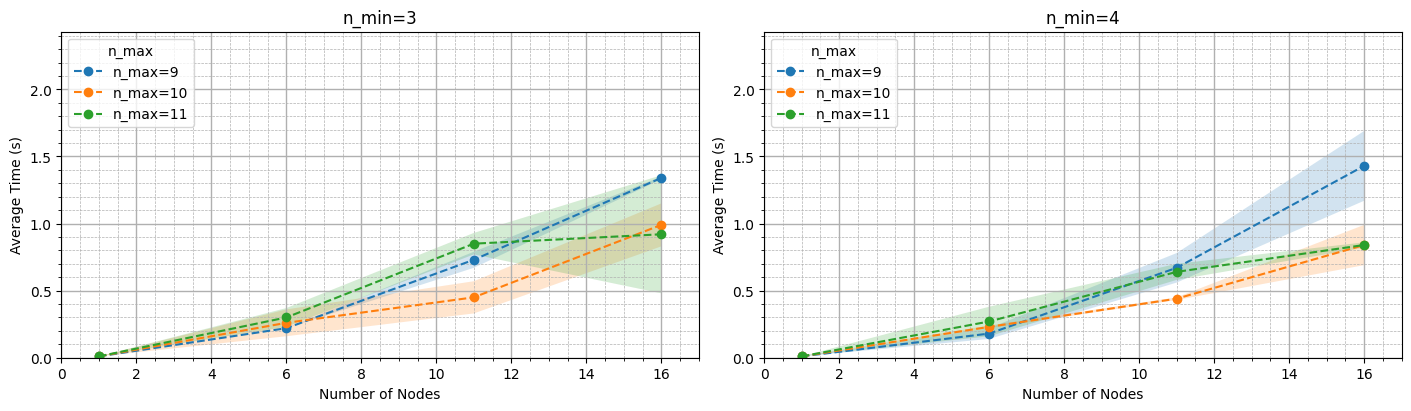

In [271]:
def run_association_simulations(sf, splits_nodes=4, range_n_min=range(0, 5), range_n_max=range(8, 14), number_of_runs=20, tag=None):
        
    records = []

    print(f"Running:")
    n_nodes_range = list(range(1, sf.max_nodes() + 1, int(sf.max_nodes() / splits_nodes)))
    if n_nodes_range[-1] != sf.max_nodes():
        n_nodes_range[-1] = sf.max_nodes()

    for n_nodes in n_nodes_range:
        print(f"  n_nodes = {n_nodes}    n_min = ", end="")
        for n_min in range_n_min:
            print(f"{n_min} (n_max = ", end="")
            for n_max in range_n_max:
                print(n_max, end=" ")
                times = [
                    OpenSwarmNetworkSimulation(SimConfig(sf, n_nodes, debug=False, n_min=n_min, n_max=n_max)).run().duration_complete_join
                    for _ in range(number_of_runs)
                ]
                # get avg and std
                records.append({
                    "n_nodes": n_nodes,
                    "n_min": n_min,
                    "n_max": n_max,
                    "avg": round(np.mean(times) / 1000, 2),
                    "std": round(np.std(times) / 1000, 2),
                })
            print(")  ", end="")
        print("")
    print("")

    df = pd.DataFrame(records)
    if tag:
        df.to_csv(f"csv/assoc-time-{tag}.csv")
    return df

# sf = sf_simple
# sf = sf_configs.slotframes[0]
sf = sf_configs.slotframes[6]

print("For this slotframe configuration:")
sf.show(compact=True)

# df = run_association_simulations(sf, splits_nodes=3, range_n_min=range(3, 4), range_n_max=range(9, 11), number_of_runs=2) # -> fixed n_min = 3
df = run_association_simulations(sf, splits_nodes=3, range_n_min=range(3, 5), range_n_max=range(9, 12), number_of_runs=2, tag="example") # variable n_min
# display(df)
plot_association_simulation_results_grid(df)

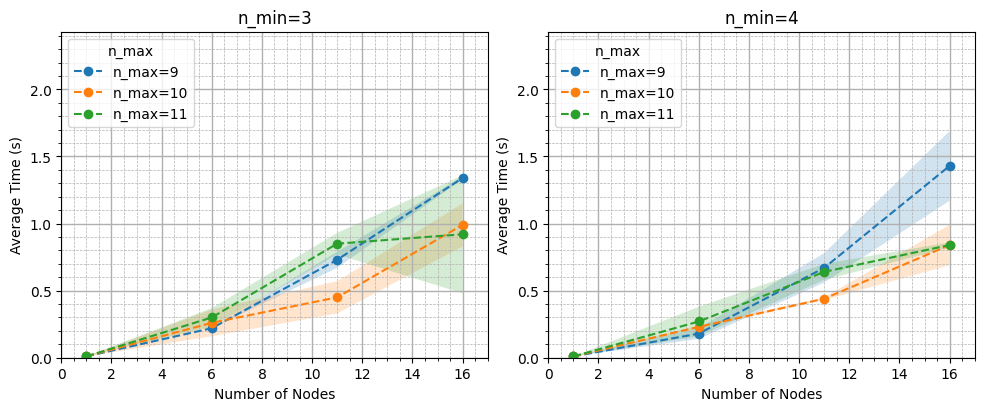

In [272]:
def plot_association_simulation_results_grid(df, tag=None, columns=2):
    # Precompute consistent axis limits
    x_min, x_max = df['n_nodes'].min(), df['n_nodes'].max()
    y_min, y_max = df['avg'].min(), df['avg'].max()

    # Get unique n_min values and set up grid layout
    n_min_values = sorted(df['n_min'].unique())
    rows = math.ceil(len(n_min_values) / columns)

    fig, axes = plt.subplots(rows, columns, figsize=(14, rows * 4), constrained_layout=True)

    # Flatten axes array for easier indexing
    axes = axes.flatten()

    # Loop through each n_min and its corresponding subplot
    for idx, n_min in enumerate(n_min_values):
        ax = axes[idx]
        group_min = df[df['n_min'] == n_min]

        # Group by n_max for each n_min
        for n_max, group in group_min.groupby('n_max'):
            ax.plot(
                group['n_nodes'],
                group['avg'],
                '--o',
                label=f'n_max={n_max}'
            )
            ax.fill_between(
                group['n_nodes'],
                group['avg'] - group['std'],
                group['avg'] + group['std'],
                alpha=0.2
            )

        # Set axis limits for consistency
        ax.set_xlim(0, x_max + 1)
        ax.set_ylim(0, y_max + 1)

        # Add labels, title, and grid
        ax.set_xlabel('Number of Nodes')
        ax.set_ylabel('Average Time (s)')
        ax.set_title(f'n_min={n_min}')
        ax.grid(True, which='major', linestyle='-', linewidth=1.0)
        ax.grid(True, which='minor', linestyle='--', linewidth=0.5)
        ax.minorticks_on()
        ax.legend(title='n_max', loc='upper left')

    # Hide unused subplots if any
    for i in range(len(n_min_values), len(axes)):
        fig.delaxes(axes[i])

    # Save the grid figure if a tag is provided
    if tag:
        plt.savefig(f"fig/assoc-time-grid-{tag}.pdf")
    plt.show()

# Example usage
plot_association_simulation_results_grid(df, tag="grid_example", columns=3)

# Handover

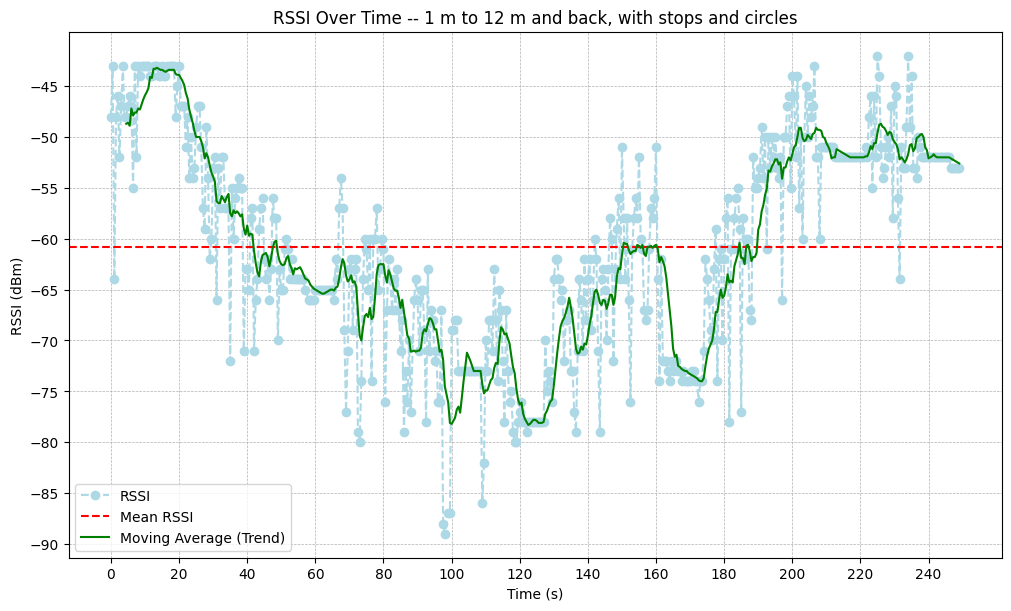

In [93]:
def rssi_get_df(filename):

    # Log data from file
    with open(filename, 'r') as file:
        log_data = file.read()

    # Parse the log
    lines = log_data.splitlines()
    rssi_values = []
    timestamp = 0

    for line in lines:
        if "received packet with rssi:" in line:
            # Extract the RSSI value
            rssi = int(line.split(":")[-1].strip())
            rssi_values.append({"timestamp": timestamp, "rssi": rssi})
        timestamp += 500  # Increment timestamp by 500 ms

    # Convert to DataFrame
    df = pd.DataFrame(rssi_values)
    # display(df.head())
    return df

def rssi_plot(df, subtitle="", tag=""):
    df['timestamp_sec'] = df['timestamp'] / 1000

    # Compute a simple moving average (window size of 5)
    window_size = 10
    df['moving_avg'] = df['rssi'].rolling(window=window_size).mean()

    # Downsample the moving average for fewer points
    downsample_factor = 2
    df['moving_avg_downsampled'] = df['moving_avg'][::downsample_factor]

    # Plot RSSI over time
    plt.figure(figsize=(10, 6), constrained_layout=True)
    plt.plot(df['timestamp_sec'], df['rssi'], marker='o', linestyle='--', color='lightblue', label='RSSI')
    plt.axhline(y=df['rssi'].mean(), color='red', linestyle='--', label='Mean RSSI')
    plt.plot(
        df['timestamp_sec'], 
        df['moving_avg'], 
        linestyle='-', color='green', label='Moving Average (Trend)'
    )

    # set min and max values for y-axis and x-axis
    # plt.ylim(-80, -40)
    # plt.xlim(-10_000, 260_000)

    plt.xticks(ticks=range(0, int(df['timestamp_sec'].max()) + 1, 20))
    plt.yticks(ticks=range(-90, -40, 5))

    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('RSSI (dBm)')
    plt.title(f'RSSI Over Time -- {subtitle}')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend()
    if tag:
        plt.savefig(f"fig/rssi-{tag}.pdf")
    plt.show()

# plotting collected data when running the dotbot for:
filename = "data/rssi-24_dec_2024-main_corridor_12_to_1_meters.txt"
# filename = "data/rssi-24_dec_2024-main_corridor-go_back_middle_circle.txt"

# rssi_plot(rssi_get_df("data/rssi-24_dec_2024-main_corridor_12_to_1_meters.txt"), subtitle="from 12 m to 1m", tag="24_dec_2024-12_to_1")
# rssi_plot(rssi_get_df("data/rssi-24_dec_2024-main_corridor-go_back_middle_circle.txt"), subtitle="1 m to 12 m and back, then mid/circle etc.")
rssi_plot(rssi_get_df("data/rssi-24_dec_2024-main_corridor-go_back_middle_circle-2.txt"), subtitle="1 m to 12 m and back, with stops and circles", tag="24_dec_2024-1_to_12_back_mid_circle")

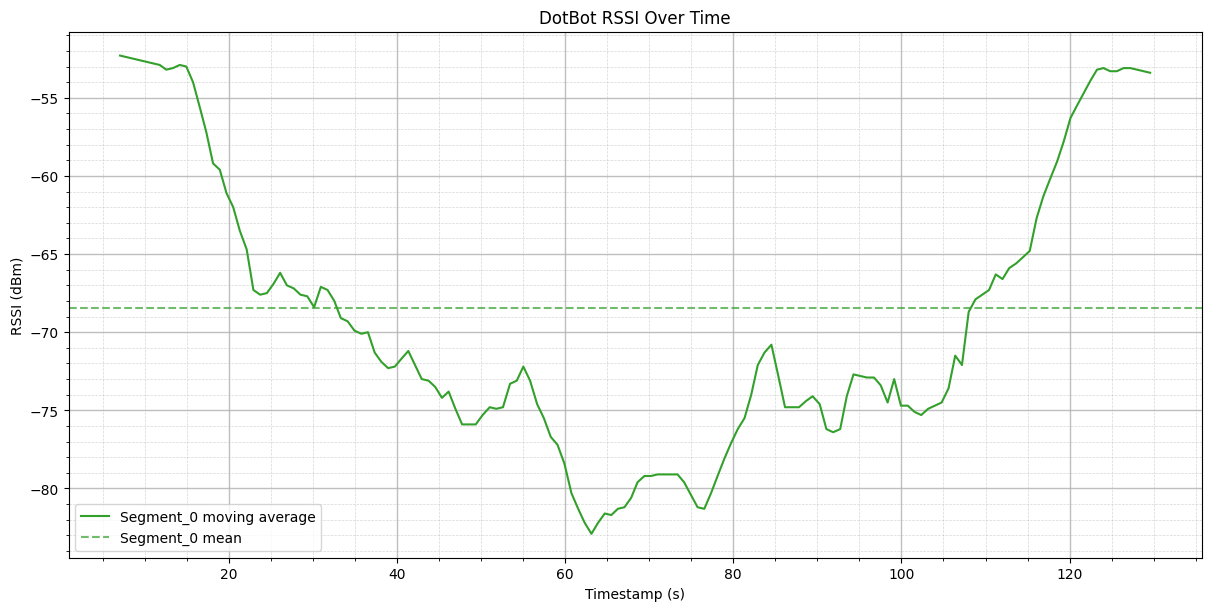

In [365]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def dotbot_rssi_to_df(filename, fix_ts_from_zero=False):
    """
    Parses a file containing DotBot RSSI logs and returns a dictionary of DataFrames with normalized timestamps.

    Args:
        filename (str): Path to the log file.

    Returns:
        dict: A dictionary where keys are segment names and values are DataFrames.
    """
    data = []

    with open(filename, 'r') as file:
        parsing = False
        for line in file:
            line = line.strip()

            if line == "START":
                parsing = True
                continue

            if line == "STOP":
                break

            if parsing:
                try:
                    pairs = line.split()
                    for pair in pairs:
                        timestamp, rssi = pair.split(';')
                        data.append((int(timestamp), int(rssi)))
                except ValueError:
                    # Skip lines that don't match the expected format
                    continue

    # Convert data to a DataFrame
    if data:
        df = pd.DataFrame(data, columns=['timestamp', 'rssi'])
        if fix_ts_from_zero:
            df['timestamp'] -= df['timestamp'].min()
        # normalize to milliseconds
        df['timestamp'] /= 1000
        return df
    
def split_df_into_segments(df):
    dataframes = []

    # Calculate time differences
    df['time_diff'] = df['timestamp'].diff().fillna(0)

    # Split into separate DataFrames based on time difference > 10,000 milliseconds (10 seconds)
    split_indices = df[df['time_diff'] > 10_000].index
    start_idx = 0

    for split_idx in split_indices:
        segment = df.iloc[start_idx:split_idx].drop(columns=['time_diff'])
        if len(segment) >= 10:  # Only keep segments with 10 or more points
            segment['timestamp'] = (segment['timestamp'] - segment['timestamp'].iloc[0])
            dataframes.append(segment)
        start_idx = split_idx

    # Add the remaining data as a final DataFrame
    if start_idx < len(df):
        segment = df.iloc[start_idx:].drop(columns=['time_diff'])
        if len(segment) >= 10:  # Only keep segments with 10 or more points
            segment['timestamp'] = (segment['timestamp'] - segment['timestamp'].iloc[0])
            dataframes.append(segment)

    return dataframes

def fix_dfs(dfs):
    # rename segments
    dfs["start-close"] = dfs.pop("Segment_1")
    dfs["start-middle"] = dfs.pop("Segment_2")
    dfs["start-far"] = dfs.pop("Segment_3")

    # ignore the one with gateway in the middle
    dfs.pop("start-middle")

    # adjust timestamps to better match plot
    dfs["start-far"] = dfs["start-far"][dfs["start-far"]["timestamp"] > 18_000]
    dfs["start-far"]["timestamp"] -= 18_000
    return dfs

def dotbot_rssi_plot(dataframes, tag=None, show_raw=False, window_size=10, handover_ts_list=[], rssi_threshold=None, rssi_hysteresis=None):
    """
    Plots the RSSI values over time for all DataFrames in the dictionary, including moving averages.

    Args:
        dataframes (dict): Dictionary where keys are segment names and values are DataFrames.
    """
    plt.figure(figsize=(12, 6), constrained_layout=True)
    
    colors = plt.cm.Paired(np.linspace(0.3, 0.7, len(dataframes)))
    largest_x = 0

    for i, (df, color) in enumerate(zip(dataframes, colors)):
        # Calculate and plot the moving average
        if window_size:
            moving_avg = df['rssi'].rolling(window=window_size).mean()
        else:
            # don't compute a moving average, it probably has already been incorporated in this df
            moving_avg = df['rssi']

        plt.plot(df['timestamp']/ 1000, moving_avg, color=color, linestyle='-', label=f"Segment_{i} moving average")


        if window_size:
            if show_raw:
                # plot the raw data
                plt.scatter(df['timestamp'] / 1000, df['rssi'], color=color, label=f"Segment_{i} (raw)", alpha=0.5)
        else:
            if show_raw and 'rssi_orig' in df.columns: # test if column rssi_orig exists
                plt.scatter(df['timestamp'] / 1000, df['rssi_orig'], color=color, label=f"Segment_{i} points", alpha=0.5)

        plt.axhline(y=df['rssi'].mean(), color=color, linestyle='--', alpha=0.7, label=f"Segment_{i} mean")

        if df['timestamp'].max() > largest_x:
            largest_x = df['timestamp'].max()

    # plt.xticks(ticks=range(0, int(largest_x / 1000) + 10, 10))
    # plt.yticks(ticks=range(-90, -40, 5))

    for i, handover_ts in enumerate(handover_ts_list):
        label = 'Device is ready for handover' if i == 0 else None
        plt.axvline(x=handover_ts / 1000, color='purple', linestyle='--', alpha=0.3, label=label)

    if rssi_threshold and rssi_hysteresis:
        plt.axhline(y=rssi_threshold, color='red', linestyle='--', label='RSSI Threshold')
        # paint the hysteresis area with alpha 0.2
        plt.axhspan(rssi_threshold - rssi_hysteresis, rssi_threshold, color='red', alpha=0.2, label='RSSI Hysteresis')

    plt.title('DotBot RSSI Over Time')
    plt.xlabel('Timestamp (s)')
    plt.ylabel('RSSI (dBm)')
    plt.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=0.8)
    plt.grid(True, which='minor', linestyle='--', linewidth=0.5, alpha=0.5)
    plt.minorticks_on()
    plt.legend()
    if tag:
        plt.savefig(f"fig/rssi-dotbot-{tag}.pdf")
    plt.show()


df = dotbot_rssi_to_df('data/rssi-26_dec_2024-db_log_3times.txt')
dfs = split_df_into_segments(df)
# dfs = fix_dfs(dfs)

# df = dotbot_rssi_to_df('data/rssi-02_jan_2025-main_corridor_go_back-2-first-last.txt')
# dfs = split_df_into_segments(df)
dfs = [dfs[0]]

dotbot_rssi_plot(dfs, tag="02_jan_2025", window_size=10, show_raw=False)
# dfs[0]

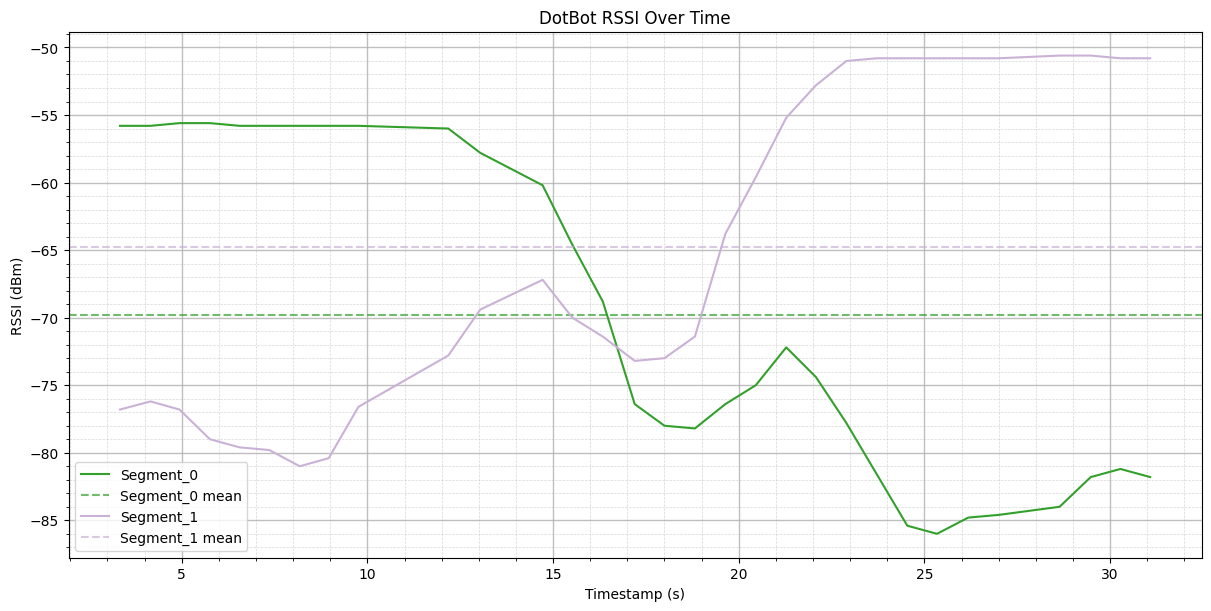

,timestamp,rssi
0,0.000,-56
1,799.968,-56
2,1619.941,-56
3,2439.914,-55
4,3339.884,-56
5,4159.857,-56
6,4939.831,-55
7,5759.803,-56
8,6559.777,-56
9,7359.750,-56


In [284]:
# create a copy of dfs[0], but have the rssi column be reversed (to simulate the bot going back)
df_rev = dfs[0].copy()
df_rev['rssi'] = df_rev['rssi'].values[::-1]
df_rev['rssi'] = df_rev['rssi'] + 5 # make it a bit stronger

# also have another copy, where the reversed rssi values are shifted back by X seconds
df_rev_shifted = df_rev.copy()
df_rev_shifted['timestamp'] -= 5_000
df_rev_shifted = df_rev_shifted[df_rev_shifted['timestamp'] > -1_800] # cut off the first 5 seconds of the reversed data

# dfs = [dfs[0], df_rev, df_rev_shifted]
dfs_adjusted = [dfs[0], df_rev]

dotbot_rssi_plot(dfs_adjusted, tag="02_jan_2025-with_rev", show_raw=False, window_size=5)
dfs_adjusted[0]

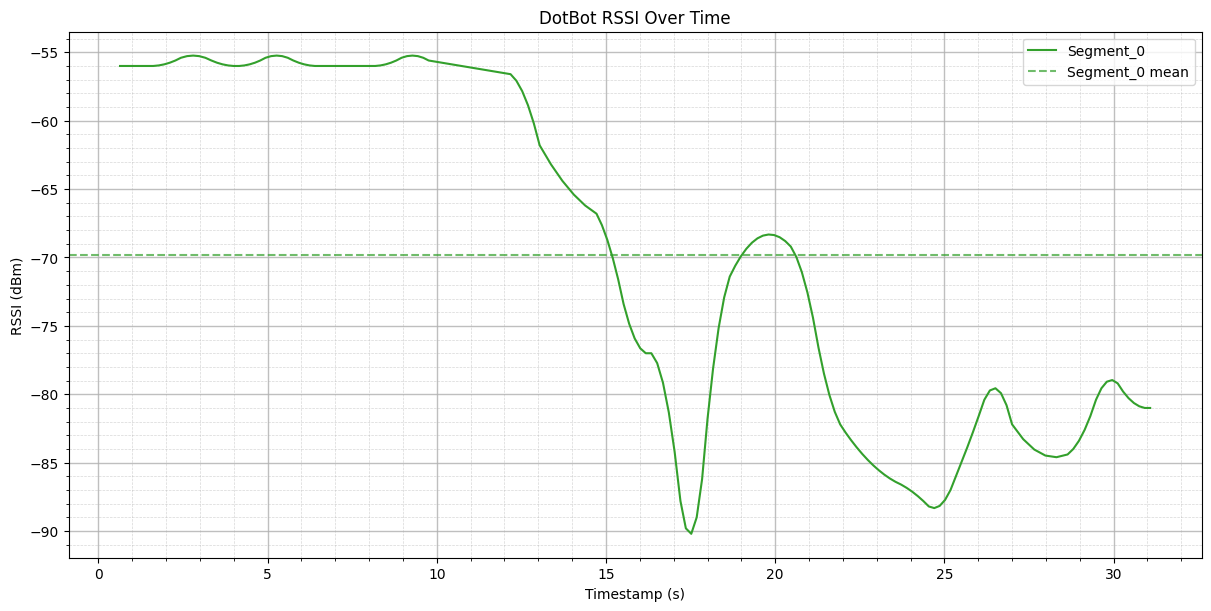

,timestamp,rssi
0,0.0000,-56.0
1,159.9936,-56.0
2,319.9872,-56.0
3,479.9808,-56.0
4,639.9744,-56.0
...,...,...
166,30438.9846,-81.0
167,30598.9792,-81.0
168,30758.9738,-81.0
169,30918.9684,-81.0


In [285]:
def expand_dataframe(df, expand_factor=1):
    import pandas as pd
    import numpy as np

    expanded_data = []

    for i in range(len(df) - 1):
        current_row = df.iloc[i]
        next_row = df.iloc[i + 1]

        # Add the current row as a dictionary
        expanded_data.append({'timestamp': current_row['timestamp'], 'rssi': current_row['rssi']})

        # Generate intermediate rows
        for j in range(1, expand_factor + 1):
            fraction = j / (expand_factor + 1)
            interpolated_timestamp = current_row['timestamp'] + fraction * (next_row['timestamp'] - current_row['timestamp'])
            interpolated_rssi = current_row['rssi'] + fraction * (next_row['rssi'] - current_row['rssi'])
            expanded_data.append({'timestamp': interpolated_timestamp, 'rssi': interpolated_rssi})

    # Add the last row
    expanded_data.append(df.iloc[-1])

    return pd.DataFrame(expanded_data)

df_expanded = expand_dataframe(dfs_adjusted[0], expand_factor=4)
# dotbot_rssi_plot([dfs_adjusted[0]], show_raw=False, window_size=5)
dotbot_rssi_plot([df_expanded], show_raw=False, window_size=5)
df_expanded

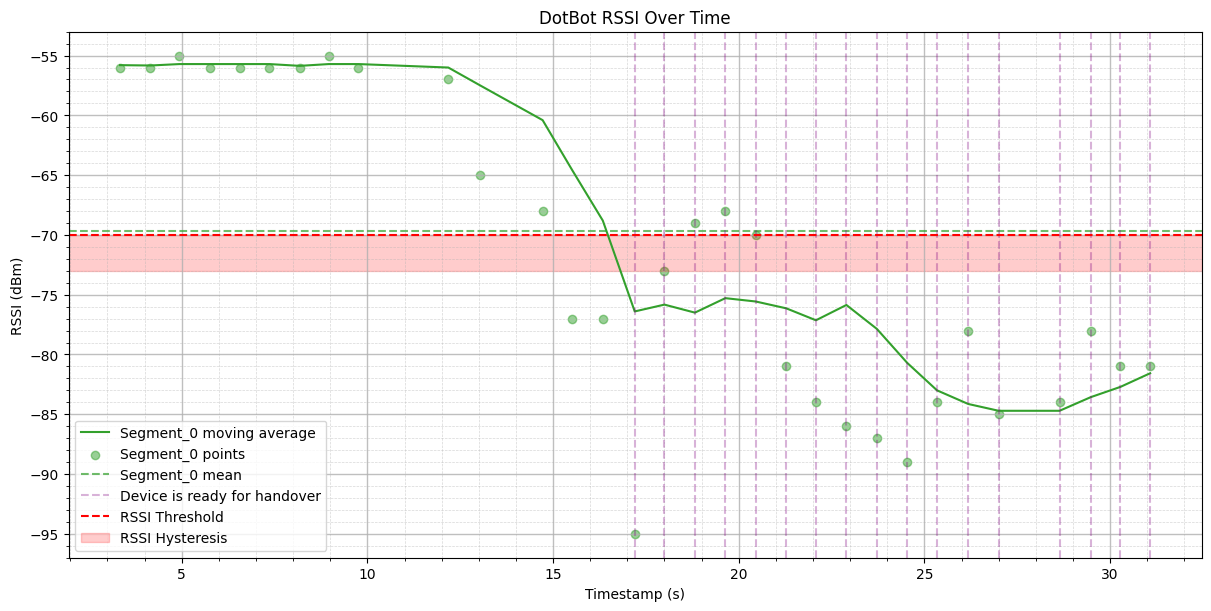

In [373]:
@dataclass
class SimulateHandover:
    rssi_df: dict
    rssi_threshold: int = -70
    rssi_hysteresis: int = 5

    def run(self):
        """
        Simulates a handover based on:
            - A list of timestamped RSSI values
            - RSSI threshold
            - RSSI hysteresis

        Returns:
            - list: A list of timestamps when a handover should occur.
            - pd.DataFrame: A DataFrame with RSSI values and timestamps that were used (not discarded) in the computation of the decision.

        The algorithm uses an RSSI average over a window of RSSI values to determine when a handover should occur.
            - The window size is parameterized with min and max values
            - To discard old RSSI values, a window max duration is parameterized
        """

        rssi_window_min_size = 5
        rssi_window_max_size = 10
        rssi_window_max_duration = 5_000
        rssi_window = []
        handover_ts_list = []
        used_rssi_values = []
        for ts, rssi in self.rssi_df:
            ts = round(ts, 2)

            # discard old RSSI values
            i = 0
            while i < len(rssi_window) and ts - rssi_window[i][0] > rssi_window_max_duration:
                rssi_window.pop(i)
                i += 1

            # include the new RSSI value
            if len(rssi_window) < rssi_window_max_size:
                rssi_window.append((ts, rssi))

            # skip if the window is not big enough yet
            if len(rssi_window) < rssi_window_min_size:
                # print(ts, rssi, None, f"\twlen={len(rssi_window)}, window={rssi_window}")
                continue

            # calculate the average RSSI value
            rssi_avg = round(np.mean([rssi for ts, rssi in rssi_window]), 2)
            used_rssi_values.append((ts, rssi_avg, rssi))
            # print(ts, rssi, rssi_avg, f"\twlen={len(rssi_window)}, window={rssi_window}")

            # check if device is ready to perform handover
            if rssi_avg < (self.rssi_threshold - self.rssi_hysteresis):
                handover_ts_list.append(ts)

        df = pd.DataFrame(used_rssi_values, columns=['timestamp', 'rssi', 'rssi_orig'])

        return handover_ts_list, df

# df_in = split_df_into_segments(dotbot_rssi_to_df('data/rssi-26_dec_2024-db_log_3times.txt', fix_ts_from_zero=True))[0]
df_in = split_df_into_segments(dotbot_rssi_to_df('data/rssi-02_jan_2025-main_corridor_go_back-2-first-last.txt', fix_ts_from_zero=True))[0]

# df_in = expand_dataframe(df_in, expand_factor=4)

sim_ho = SimulateHandover(
    df_in[['timestamp', 'rssi']].values,
    rssi_threshold=-70,
    rssi_hysteresis=3
)
handover_ts_list, df_out = sim_ho.run()

dotbot_rssi_plot([df_out], show_raw=True, window_size=None, handover_ts_list=handover_ts_list, rssi_threshold=sim_ho.rssi_threshold, rssi_hysteresis=sim_ho.rssi_hysteresis)
# dotbot_rssi_plot([df_in], show_raw=True, window_size=None, handover_ts_list=handover_ts_list, rssi_threshold=RSSI_THRESHOLD, rssi_hysteresis=RSSI_HYSTERESIS)

# Channel Hopping

n_cells: 13, n_regular_freqs: 12, n_beacon_freqs: 3
my_uplink_cell: ('U', 6, 1)


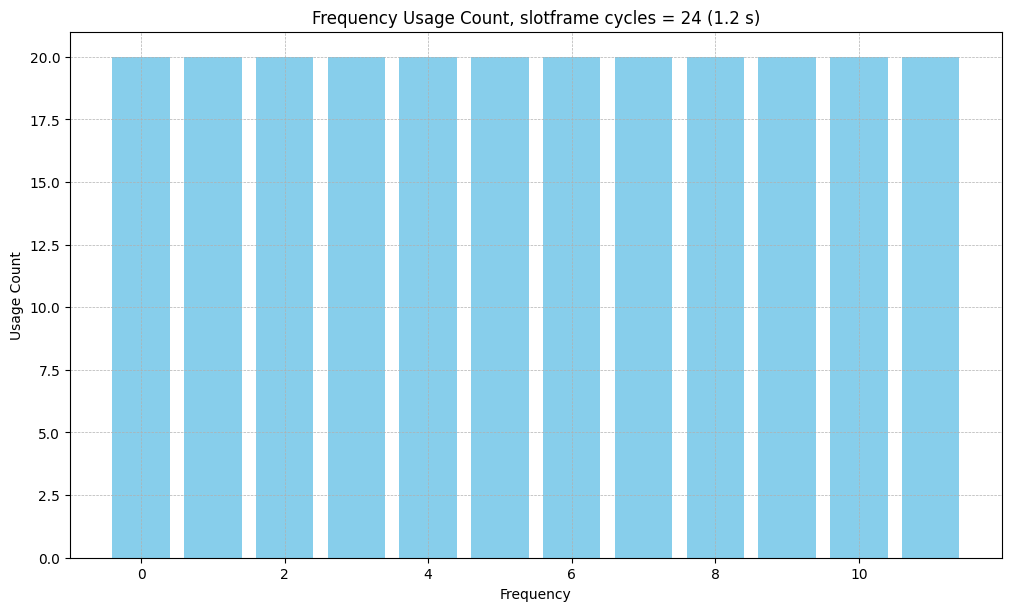

In [84]:
def dotbot_compute_radio_action(join_state, cell_type, cell_assigned_id, my_id):
    if cell_type in ['B', 'D']:
        return '>> rx'
    elif cell_type == 'S':
        if join_state == 'joined':
            return 'sleep...'
        else:
            return '>> tx' # subject to backoff allowing it
    elif cell_type == 'U':
        if cell_assigned_id == my_id:
            return 'tx >>'
        else:
            return 'sleep...' # could also be 'rx' if we want to listen to Beacons, for faster handovers


def compute_radio_frequency(asn, channel_offset, frequencies):
    """frequency = F {(ASN + channelOffset) mod nFreq}, see RFC 7554, Appendix A.7"""
    freq_index = (asn + channel_offset) % len(frequencies)
    return frequencies[freq_index]


def run_radio_schedule(cells, regular_frequencies, beacon_frequencies, my_id, sf_cycles, debug=False, random_hop_beacon_freqs=False):
    asn_max = len(cells) * sf_cycles

    my_uplink_cell = next((cell for i, cell in enumerate(cells) if cell[2] == my_id), None)
    print(f"n_cells: {len(cells)}, n_regular_freqs: {len(regular_frequencies)}, n_beacon_freqs: {len(beacon_frequencies)}")
    print(f"my_uplink_cell: {my_uplink_cell}")

    asn = 0
    cell_id = 0
    beacon_cell_id = 0
    used_regular_frequencies_stats = {f: 0 for f in regular_frequencies}
    while asn < asn_max:
        type, channel_offset, assigned_node_id = cells[cell_id]

        radio_action = dotbot_compute_radio_action("joined", type, assigned_node_id, my_id)
        if type == 'B':
            if random_hop_beacon_freqs:
                radio_frequency = compute_radio_frequency(asn, channel_offset, beacon_frequencies)
            else:
                radio_frequency = beacon_frequencies[beacon_cell_id]
                beacon_cell_id = (beacon_cell_id + 1) % len(beacon_frequencies)
        else:
            radio_frequency = compute_radio_frequency(asn, channel_offset, regular_frequencies)
            used_regular_frequencies_stats[radio_frequency] += 1

        if debug:
            print(f"---") if asn % len(cells) == 0 else None
            print(f"asn {asn:4}, channel_offset {channel_offset:3}", end='    ')
            print(f"cell {cell_id:3}-{type} is {radio_action:10} on frequency {radio_frequency}")

        # increment asn and cell_id
        asn += 1
        cell_id = (cell_id + 1) % len(cells)

    # return frequencies usage stats as df
    return pd.DataFrame(list(used_regular_frequencies_stats.items()), columns=["frequency", "used_times"])


def plot_frequency_usage(df, sf_duration, sf_cycles, tag=None):
    plt.figure(figsize=(10, 6), constrained_layout=True)
    plt.bar(df['frequency'], df['used_times'], color='skyblue')
    plt.title(f'Frequency Usage Count, slotframe cycles = {sf_cycles} ({round(sf_duration * sf_cycles / 1000, 2)} s)')
    plt.xlabel('Frequency')
    plt.ylabel('Usage Count')
    plt.grid(True, linestyle='--', linewidth=0.5)
    if tag:
        plt.savefig(f"fig/freq-usage-{tag}.pdf")
    plt.show()


cells = [
    # id of the cell, type of the cell, channel offset, id of the node assigned for uplink

    # beacon cells use their own set of frequencies, and thus, a separate set of channel offsets
    ('B', 0, None),
    ('B', 1, None),
    ('B', 2, None),

    # regular cells
    ('S', 3, None),
    ('D', 9, None),
    ('U', 1, None),
    ('U', 6, 1),
    ('S', 0, None),
    ('D', 4, None),
    ('U', 5, None),
    ('U', 2, None),
    ('U', 8, None),
    ('U', 7, None)
]
regular_frequencies = [3, 8, 1, 6, 10, 11, 0, 9, 4, 7, 2, 5] # range(15-3)
beacon_frequencies = [12, 13, 14] # range(15-3, 15)
my_id = 1
sf_duration = 50 # ms
sf_cycles = 24

df = run_radio_schedule(
    cells,
    regular_frequencies,
    beacon_frequencies,
    my_id,
    sf_cycles=sf_cycles,
    random_hop_beacon_freqs=False, # if True, will randomly hop beacon frequencies; else, will use them in order (effectively ignoring the channel offset for beacons)
    debug=False
)
plot_frequency_usage(df, sf_duration, sf_cycles=sf_cycles, tag="sf_101")

In [398]:

my_id = 1
sf = copy.deepcopy(sf_good)
sf.slots[4].assign_node_id(my_id)
sf.show()
cells = sf.get_cell_tuples()
sf_cycles = 200

# df = run_radio_schedule(cells, BLE_FREQUENCIES, BLE_ADV_FREQUENCIES, my_id, sf_cycles=sf_cycles, hop_beacon_freqs=False, debug=False)
# plot_frequency_usage(df, sf.duration, sf_cycles=sf_cycles, tag="sf_101")

[B↓[B↓[B↓[S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][
U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D
↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][S][D↓[U][U]
[U][U][D↓[U][U][U][U][U][S][D↓[U][U][U][U][D↓[U][U][U][U][U][U][U]

In [413]:
def one_slotframe_schedule_c(sf, i):
    cells = ",\n        ".join([slot.repr_c_cells() for slot in sf.slots])
    trailing_zero = ",\n        0" if len(sf.slots) < 101 else ""

    name = f"schedule_{sf.label}"

    return name, f"""\
/* Schedule with {len(sf.slots)} slots, supporting up to {sf.max_nodes()} nodes */
schedule_t {name} = {{
    .id = {i},
    .max_nodes = {sf.max_nodes()},
    .backoff_n_min = 5,
    .backoff_n_max = 9,
    .slot_duration_us = {round(sf.slot_duration * 1000)},
    .n_cells = {len(sf.slots)},
    .cells = {{
        {cells}{trailing_zero}
    }}
}}
"""

def all_slotframes_schedule_c(sfs):
    """Return it like a C struct."""
    # sfs = sorted(sfs, key=lambda sf: sf.max_nodes())

    prefix_str = f"""\
#define N_BLE_FREQUENCIES 37
#define N_BLE_ADV_FREQUENCIES 3
#define N_CELLS_MAX 101
#define N_SCHEDULES {len(sfs)}

const uint8_t BLE_FREQUENCIES[] = {{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36}};
const uint8_t BLE_ADV_FREQUENCIES[] = {{37, 38, 39}};

typedef struct {{
    char type;
    uint8_t channel_offset;
    node_id_t assigned_node_id;
}} cell_t;

typedef struct {{
    uint8_t id; // unique identifier for the schedule
    uint8_t max_nodes; // maximum number of nodes that can be scheduled, equivalent to the number of uplink slots
    uint8_t backoff_n_min; // minimum exponent for the backoff algorithm
    uint8_t backoff_n_max; // maximum exponent for the backoff algorithm
    uint16_t slot_duration_us; // duration of a slot in microseconds
    size_t n_cells; // number of cells in this schedule
    cell_t cells[N_CELLS_MAX]; // cells in this schedule
}} schedule_t;

"""

    schedules = [one_slotframe_schedule_c(sf, i+1) for i, sf in enumerate(sfs)]
    schedules_str = "\n".join([schedule for _name, schedule in schedules])

#     names_str = ",\n    ".join([name for name, _schedule in schedules])
#     schedules_list_str = f"""\
# schedule_t schedules[N_SCHEDULES] = {{
#     {names_str}
# }}
# """
    schedules_list_str = ""

    return prefix_str + schedules_str + schedules_list_str

sf = Slotframe.build_blocks2(data_slots="SDUU", repeats_data=2, assoc_slots="B", label="test")
sf.show()

print(all_slotframes_schedule_c([sf]))

[B↓[S][D↓[U][U][S][D↓[U][U][U][U]

#define N_BLE_FREQUENCIES 37
#define N_BLE_ADV_FREQUENCIES 3
#define N_CELLS_MAX 101
#define N_SCHEDULES 1

const uint8_t BLE_FREQUENCIES[] = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36};
const uint8_t BLE_ADV_FREQUENCIES[] = {37, 38, 39};

typedef struct {
    char type;
    uint8_t channel_offset;
    node_id_t assigned_node_id;
} cell_t;

typedef struct {
    uint8_t id; // unique identifier for the schedule
    uint8_t max_nodes; // maximum number of nodes that can be scheduled, equivalent to the number of uplink slots
    uint8_t backoff_n_min; // minimum exponent for the backoff algorithm
    uint8_t backoff_n_max; // maximum exponent for the backoff algorithm
    uint16_t slot_duration_us; // duration of a slot in microseconds
    size_t n_cells; // number of cells in this schedule
    cell_t cells[N_CELLS_MAX]; // cells in this schedule
} schedule_t;

/* Schedule with 11 slots, support

In [417]:
print(all_slotframes_schedule_c(sf_configs.slotframes[:]))


#define N_BLE_FREQUENCIES 37
#define N_BLE_ADV_FREQUENCIES 3
#define N_CELLS_MAX 101
#define N_SCHEDULES 5

const uint8_t BLE_FREQUENCIES[] = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36};
const uint8_t BLE_ADV_FREQUENCIES[] = {37, 38, 39};

typedef struct {
    char type;
    uint8_t channel_offset;
    node_id_t assigned_node_id;
} cell_t;

typedef struct {
    uint8_t id; // unique identifier for the schedule
    uint8_t max_nodes; // maximum number of nodes that can be scheduled, equivalent to the number of uplink slots
    uint8_t backoff_n_min; // minimum exponent for the backoff algorithm
    uint8_t backoff_n_max; // maximum exponent for the backoff algorithm
    uint16_t slot_duration_us; // duration of a slot in microseconds
    size_t n_cells; // number of cells in this schedule
    cell_t cells[N_CELLS_MAX]; // cells in this schedule
} schedule_t;

/* Schedule with 137 slots, suppor

# OTAP algorithm

In [416]:
def simulate_otap_with_assigned_slots(nodes, firmware_chunks, slotframe, max_retries=5, success_probability=0.9):
    """
    Simulate OTAP with a custom slotframe configuration and assigned uplink slots.
    """
    # Gateway and node state
    chunk_status = {node_id: set() for node_id in nodes}  # Received chunks per node
    missing_chunks = {node_id: set(firmware_chunks) for node_id in nodes}  # Missing chunks per node
    retry_counts = {node_id: 0 for node_id in nodes}  # Retry counters
    node_processed_chunks = {node_id: set() for node_id in nodes}  # Processed chunks at nodes

    def all_chunks_received():
        return all(len(chunk_status[node_id]) == len(firmware_chunks) for node_id in nodes)

    if type(slotframe) is not list:
        slotframe = slotframe.get_cell_tuples()
    
    # Simulate slotframes
    # for frame in range(num_slotframes):
    frame = 0
    while not all_chunks_received():
        frame += 1
        # print(f"\n--- Slotframe {frame} --- ")
        for slot_index, (slot_type, _co, assigned_node) in enumerate(slotframe):
            # print(f"Slot {slot_index + 1} ({slot_type}):", end='    ')

            if slot_type == "D":
                # Downlink slot: Send firmware chunks to all nodes
                for node_id in nodes:
                    # if retry_counts[node_id] > max_retries:
                    #     # print(f"  Node {node_id}: Exceeded max retries, skipping future attempts.")
                    #     continue
                    if missing_chunks[node_id]:
                        chunk_id = list(missing_chunks[node_id])[0]
                        # Simulate success with 90% probability
                        if random.random() < success_probability:
                            node_processed_chunks[node_id].add(chunk_id)
                            missing_chunks[node_id].remove(chunk_id)
                            # print(f"  Node {node_id}: Successfully received chunk {chunk_id}")
                        else:
                            # print(f"  Node {node_id}: Failed to receive chunk {chunk_id}")
                            retry_counts[node_id] += 1
            elif slot_type == "U" and assigned_node is not None:
                # Uplink slot: Specific node reports its ACKs
                node_id = assigned_node
                assert node_id in nodes, f"Uplink slot assigned to unknown node {node_id}."
                acks = node_processed_chunks[node_id]
                # input(f"node {node_id} acks {acks}")
                chunk_status[node_id].update(acks)
                missing_chunks[node_id] -= acks
                # print(f"  Node {node_id}: Sent ACKs {sorted(acks)}")

    # Final state
    print(f"\n\nFinal Chunk Status (total chunks = {len(firmware_chunks)}) after {frame} slotframes:")
    for node_id, status in chunk_status.items():
        print(f"Node {node_id}: Received chunks {sorted(status)}")


nodes = [0, 1, 2, 3, 4, 5]  # Six nodes
firmware_chunks = list(range(1, 10))
slotframe_cells = [
    ('B', None, None),
    ('S', None, None),
    ('D', None, None),
    ('U', None, 0),
    ('U', None, 1),
    ('S', None, None),
    ('D', None, None),
    ('U', None, 2),
    ('U', None, 3),
    ('U', None, 4),
    ('U', None, None),
]

# nodes = list(range(101))
# firmware_chunks = list(range(1, math.ceil(30_000 / 128) + 1)) # 30 KB firmware, 128 B chunks

# sf = copy.deepcopy(sf_good)
# [ sf.assign_next_available_uplink_slot(i) for i, _node_id in enumerate(nodes) ]
# slotframe_cells = sf.get_cell_tuples()

simulate_otap_with_assigned_slots(
    nodes,
    firmware_chunks,
    slotframe_cells,
    success_probability=0.99,
)


KeyboardInterrupt: 